## 0. Import packages

In [503]:
import pandas as pd
import numpy as np
import sys 
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append("..")

from src.support_cleaning import normalize

## 1. Data import and preliminary exploration

In [504]:
data_2013 = pd.read_csv("../data/datos-2013.csv", sep=";").assign(fichero="data_2013")
data_2013.columns = [normalize(column).replace(" ","_") for column in data_2013.columns]
print("\n\nHead:")
display(data_2013.head(5))
print("\n\nData types:")
data_2013.info()



Head:


,codigo_orgao_superior,nome_orgao_superior,codigo_orgao,nome_orgao,codigo_unidade_gestora,nome_unidade_gestora,categoria_economica,origem_receita,especie_receita,detalhamento,valor_previsto_atualizado,valor_lancado,valor_realizado,percentual_realizado,data_lancamento,ano_exercicio,fichero
0,63000.0,NaN,63000.0,Advocacia-Geral da União - Unidades com víncul...,110060.0,COORD. GERAL DE ORC. FIN. E ANAL. CONT. - AGU,Receitas Correntes,Outras Receitas Correntes,"Bens, Direitos e Valores Incorporados ao Patr",REC.DIVIDA ATIVA NAO TRIBUTARIA DE OUTRAS REC,"0,00","0,00","1297,13","0,00",31/12/2013,NaN,data_2013
1,63000.0,Advocacia-Geral da União,63000.0,Advocacia-Geral da União - Unidades com víncul...,110060.0,COORD. GERAL DE ORC. FIN. E ANAL. CONT. - AGU,Receitas Correntes,Outras Receitas Correntes,"Indenizações, restituições e ressarcimentos",RECUPERACAO DE DESPESAS DE EXERC. ANTERIORES,"0,00","0,00","26666621,42","0,00",31/12/2013,2013.0,data_2013
2,63000.0,Advocacia-Geral da União,63000.0,Advocacia-Geral da União - Unidades com víncul...,110060.0,COORD. GERAL DE ORC. FIN. E ANAL. CONT. - AGU,Receitas Correntes,Outras Receitas Correntes,"Multas administrativas, contratuais e judicia",OUTRAS MULTAS E JUROS DE MORA,"0,00","0,00","301251,13","0,00",31/12/2013,2013.0,data_2013
3,63000.0,NaN,63000.0,Advocacia-Geral da União - Unidades com víncul...,110060.0,COORD. GERAL DE ORC. FIN. E ANAL. CONT. - AGU,Receitas Correntes,Outras Receitas Correntes,"Bens, Direitos e Valores Incorporados ao Patr",REC.DIV.ATIVA POR INFRAÇÃO ADMINISTRATIVA,"0,00","0,00","1855,58","0,00",31/12/2013,2013.0,data_2013
4,63000.0,Advocacia-Geral da União,63000.0,Advocacia-Geral da União - Unidades com víncul...,110060.0,COORD. GERAL DE ORC. FIN. E ANAL. CONT. - AGU,Receitas Correntes,Outras Receitas Correntes,"Indenizações, restituições e ressarcimentos",OUTRAS RESTITUICOES,"0,00","0,00","52140,68","0,00",31/12/2013,2013.0,data_2013




Data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4498 entries, 0 to 4497
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   codigo_orgao_superior      4282 non-null   float64
 1   nome_orgao_superior        2924 non-null   object 
 2   codigo_orgao               4362 non-null   float64
 3   nome_orgao                 4286 non-null   object 
 4   codigo_unidade_gestora     4324 non-null   float64
 5   nome_unidade_gestora       4278 non-null   object 
 6   categoria_economica        4303 non-null   object 
 7   origem_receita             4413 non-null   object 
 8   especie_receita            4355 non-null   object 
 9   detalhamento               4377 non-null   object 
 10  valor_previsto_atualizado  4273 non-null   object 
 11  valor_lancado              4282 non-null   object 
 12  valor_realizado            4309 non-null   object 
 13  percentual_realizado       4360 no

## 1.1 Data types
Data types appear to be correct for most columns except for the following ones that are object datatypes and should instead be:
- codigo_orgao_superior: object/category
- codigo_orgao: object: object
- codigo_unidade_gestora: object
- valor_previsto_atualizado: float  
- valor_lancado: float           
- valor_realizado: float         
- percentual_realizado: float
- data_lancamento: datetime[ns]

The codes although numerical, are actually a unique representation of organizations and bear no magnitude. Thus it is more interesting to change them to object to explore their summary statistics more comfortably. 

The revenue values carry a comma instead of a floating point, making conversion to float not feasible until replaced by a point. 

Data_lancamento will just need to simply be converted to datetime.

This will have to be corrected with in the cleaning notebook with a dictionary of the sort below.

In [505]:
data_types_dict = {
    "codigo_orgao_superior": object,
    "codigo_orgao": object,  
    "codigo_unidade_gestora": object,      
    "valor_previsto_atualizado": float,
    "valor_lancado": float,  
    "valor_realizado": float,      
    "percentual_realizado": float,
    "data_lancamento": "datetime64[ns]"
}

## 1.2 Import all data, explore and concatenate

In [506]:
data_dict = {
    "data_2013": pd.read_csv("../data/datos-2013.csv", sep=";"),
    "data_2014": pd.read_csv("../data/datos-2014.csv", sep=";"),
    "data_2015": pd.read_csv("../data/datos-2015.csv", sep=";"),
    "data_2016": pd.read_csv("../data/datos-2016.csv", sep=";"),
    "data_2017": pd.read_csv("../data/datos-2017.csv", sep=";"),
    "data_2018": pd.read_csv("../data/datos-2018.csv", sep=";"),
    "data_2019": pd.read_csv("../data/datos-2019.csv", sep=";"),
    "data_2020": pd.read_csv("../data/datos-2020.csv", sep=";"),
    "data_2021": pd.read_csv("../data/datos-2021.csv", sep=";")
}

data_df = pd.DataFrame(columns=[normalize(column).replace(" ","_") for column in data_2013.columns])
for df_name, df in data_dict.items():
    df.columns = [normalize(column).replace(" ","_") for column in df.columns]
    print("\n\n\n\n------------------")
    print(f"\n{df_name}")
    print("\n\nInfo summary")
    print(df.info())
    print("\n\nDescriptive statistics summary")
    print("\nNumerical data:")
    display(df.describe().T.assign(missing_values=lambda x: df.shape[0]-x["count"]))
    print("\nObject types:")
    display(df.describe(include=['O']).T.assign(missing_values=lambda x: df.shape[0]-x["count"]))

    print("\n\nDuplicated values:")
    display(df.duplicated().sum())

    data_df = pd.concat([data_df,df.assign(fichero=df_name[-4:])])






------------------

data_2013


Info summary
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4498 entries, 0 to 4497
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   codigo_orgao_superior      4282 non-null   float64
 1   nome_orgao_superior        2924 non-null   object 
 2   codigo_orgao               4362 non-null   float64
 3   nome_orgao                 4286 non-null   object 
 4   codigo_unidade_gestora     4324 non-null   float64
 5   nome_unidade_gestora       4278 non-null   object 
 6   categoria_economica        4303 non-null   object 
 7   origem_receita             4413 non-null   object 
 8   especie_receita            4355 non-null   object 
 9   detalhamento               4377 non-null   object 
 10  valor_previsto_atualizado  4273 non-null   object 
 11  valor_lancado              4282 non-null   object 
 12  valor_realizado            4309 non-null   object 
 13 

,count,mean,std,min,25%,50%,75%,max,missing_values
codigo_orgao_superior,4282.0,31739.607660,10692.607398,20000.0,25000.0,26000.0,36000.0,81000.0,216.0
codigo_orgao,4362.0,31484.209995,10810.318732,20101.0,26000.0,26292.0,35000.0,91214.0,136.0
codigo_unidade_gestora,4324.0,232766.252775,141238.719759,110005.0,153978.0,160075.0,253003.0,913001.0,174.0
ano_exercicio,3374.0,2013.000000,0.000000,2013.0,2013.0,2013.0,2013.0,2013.0,1124.0



Object types:


,count,unique,top,freq,missing_values
nome_orgao_superior,2924,25,Ministério da Educação,1173,1574
nome_orgao,4286,264,Ministério da Economia - Unidades com vínculo ...,476,212
nome_unidade_gestora,4278,279,SETORIAL ORCAMENTARIA E FINANCEIRA / ME,392,220
categoria_economica,4303,4,Receitas Correntes,3829,195
origem_receita,4413,15,Outras Receitas Correntes,1945,85
especie_receita,4355,44,Receita de Serviços,955,143
detalhamento,4377,694,RECUPERACAO DE DESPESAS DE EXERC. ANTERIORES,210,121
valor_previsto_atualizado,4273,2646,"0,00",1546,225
valor_lancado,4282,51,"0,00",4232,216
valor_realizado,4309,3583,"0,00",678,189




Duplicated values:


np.int64(0)





------------------

data_2014


Info summary
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4553 entries, 0 to 4552
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   codigo_orgao_superior      4331 non-null   float64
 1   nome_orgao_superior        2959 non-null   object 
 2   codigo_orgao               4493 non-null   float64
 3   nome_orgao                 4439 non-null   object 
 4   codigo_unidade_gestora     4332 non-null   float64
 5   nome_unidade_gestora       4392 non-null   object 
 6   categoria_economica        4502 non-null   object 
 7   origem_receita             4487 non-null   object 
 8   especie_receita            4455 non-null   object 
 9   detalhamento               4506 non-null   object 
 10  valor_previsto_atualizado  4325 non-null   object 
 11  valor_lancado              4375 non-null   object 
 12  valor_realizado            4328 non-null   object 
 13 

C:\Users\Miguel\AppData\Local\Temp\ipykernel_22404\793846478.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_df = pd.concat([data_df,df.assign(fichero=df_name[-4:])])


,count,mean,std,min,25%,50%,75%,max,missing_values
codigo_orgao_superior,4331.0,31847.841145,10813.244886,20000.0,25000.0,26000.0,36000.0,81000.0,222.0
codigo_orgao,4493.0,31818.443356,11143.198081,20101.0,26000.0,26298.0,36201.0,91214.0,60.0
codigo_unidade_gestora,4332.0,236574.978532,145862.242362,110005.0,153167.0,160075.0,255000.0,913001.0,221.0
ano_exercicio,3415.0,2014.000000,0.000000,2014.0,2014.0,2014.0,2014.0,2014.0,1138.0



Object types:


,count,unique,top,freq,missing_values
nome_orgao_superior,2959,25,Ministério da Educação,1171,1594
nome_orgao,4439,267,Ministério da Economia - Unidades com vínculo ...,465,114
nome_unidade_gestora,4392,278,SETORIAL ORCAMENTARIA E FINANCEIRA / ME,365,161
categoria_economica,4502,5,Receitas Correntes,4051,51
origem_receita,4487,14,Outras Receitas Correntes,2025,66
especie_receita,4455,46,"Multas administrativas, contratuais e judicia",951,98
detalhamento,4506,706,RECUPERACAO DE DESPESAS DE EXERC. ANTERIORES,214,47
valor_previsto_atualizado,4325,2592,"0,00",1637,228
valor_lancado,4375,70,"0,00",4306,178
valor_realizado,4328,3560,"0,00",706,225




Duplicated values:


np.int64(0)





------------------

data_2015


Info summary
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4523 entries, 0 to 4522
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   codigo_orgao_superior      4324 non-null   float64
 1   nome_orgao_superior        2940 non-null   object 
 2   codigo_orgao               4351 non-null   float64
 3   nome_orgao                 4361 non-null   object 
 4   codigo_unidade_gestora     4326 non-null   float64
 5   nome_unidade_gestora       4449 non-null   object 
 6   categoria_economica        4463 non-null   object 
 7   origem_receita             4346 non-null   object 
 8   especie_receita            4320 non-null   object 
 9   detalhamento               4393 non-null   object 
 10  valor_previsto_atualizado  4297 non-null   object 
 11  valor_lancado              4381 non-null   object 
 12  valor_realizado            4351 non-null   object 
 13 

,count,mean,std,min,25%,50%,75%,max,missing_values
codigo_orgao_superior,4324.0,31970.860315,10941.671616,20000.0,25000.0,26000.0,36000.0,81000.0,199.0
codigo_orgao,4351.0,32019.609975,11465.439048,20101.0,26000.0,26298.0,36211.0,91214.0,172.0
codigo_unidade_gestora,4326.0,237160.818770,145720.161158,110005.0,153173.0,167086.0,264001.0,913001.0,197.0
ano_exercicio,3392.0,2015.000000,0.000000,2015.0,2015.0,2015.0,2015.0,2015.0,1131.0



Object types:


,count,unique,top,freq,missing_values
nome_orgao_superior,2940,25,Ministério da Educação,1216,1583
nome_orgao,4361,271,Ministério da Economia - Unidades com vínculo ...,466,162
nome_unidade_gestora,4449,288,SETORIAL ORCAMENTARIA E FINANCEIRA / ME,374,74
categoria_economica,4463,4,Receitas Correntes,4037,60
origem_receita,4346,14,Outras Receitas Correntes,1999,177
especie_receita,4320,41,"Multas administrativas, contratuais e judicia",927,203
detalhamento,4393,694,RECUPERACAO DE DESPESAS DE EXERC. ANTERIORES,218,130
valor_previsto_atualizado,4297,2522,"0,00",1694,226
valor_lancado,4381,82,"0,00",4300,142
valor_realizado,4351,3619,"0,00",671,172




Duplicated values:


np.int64(0)





------------------

data_2016


Info summary
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194533 entries, 0 to 194532
Data columns (total 16 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   codigo_orgao_superior      190214 non-null  float64
 1   nome_orgao_superior        126446 non-null  object 
 2   codigo_orgao               190506 non-null  float64
 3   nome_orgao                 191144 non-null  object 
 4   codigo_unidade_gestora     185211 non-null  float64
 5   nome_unidade_gestora       191552 non-null  object 
 6   categoria_economica        192399 non-null  object 
 7   origem_receita             186042 non-null  object 
 8   especie_receita            190129 non-null  object 
 9   detalhamento               186707 non-null  object 
 10  valor_previsto_atualizado  184806 non-null  object 
 11  valor_lancado              188960 non-null  object 
 12  valor_realizado            188766 non

,count,mean,std,min,25%,50%,75%,max,missing_values
codigo_orgao_superior,190214.0,32735.986836,11072.787723,20000.0,26000.0,26000.0,39000.0,81000.0,4319.0
codigo_orgao,190506.0,32087.913158,10958.211896,20101.0,26232.0,26406.0,36212.0,91214.0,4027.0
codigo_unidade_gestora,185211.0,231662.563579,143282.285279,110005.0,153165.0,167086.0,253003.0,913001.0,9322.0
ano_exercicio,145900.0,2016.000000,0.000000,2016.0,2016.0,2016.0,2016.0,2016.0,48633.0



Object types:


,count,unique,top,freq,missing_values
nome_orgao_superior,126446,25,Ministério da Educação,46771,68087
nome_orgao,191144,269,Ministério da Economia - Unidades com vínculo ...,13510,3389
nome_unidade_gestora,191552,292,SETORIAL ORCAMENTARIA E FINANCEIRA / ME,10952,2981
categoria_economica,192399,4,Receitas Correntes,184635,2134
origem_receita,186042,14,Outras Receitas Correntes,67579,8491
especie_receita,190129,44,Serviços Administrativos e Comerciais Gerais,53659,4404
detalhamento,186707,525,SERV.ADMINISTRAT.E COMERCIAIS GERAIS-PRINC.,28989,7826
valor_previsto_atualizado,184806,1758,"0,00",182993,9727
valor_lancado,188960,975,"0,00",187909,5573
valor_realizado,188766,125625,"0,00",2888,5767




Duplicated values:


np.int64(3)





------------------

data_2017


Info summary
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190479 entries, 0 to 190478
Data columns (total 16 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   codigo_orgao_superior      185999 non-null  float64
 1   nome_orgao_superior        123811 non-null  object 
 2   codigo_orgao               188418 non-null  float64
 3   nome_orgao                 185457 non-null  object 
 4   codigo_unidade_gestora     186949 non-null  float64
 5   nome_unidade_gestora       188076 non-null  object 
 6   categoria_economica        187950 non-null  object 
 7   origem_receita             181808 non-null  object 
 8   especie_receita            181798 non-null  object 
 9   detalhamento               186726 non-null  object 
 10  valor_previsto_atualizado  180955 non-null  object 
 11  valor_lancado              182124 non-null  object 
 12  valor_realizado            182807 non

,count,mean,std,min,25%,50%,75%,max,missing_values
codigo_orgao_superior,185999.0,32547.115845,10955.975665,20000.0,26000.0,26000.0,39000.0,81000.0,4480.0
codigo_orgao,188418.0,31814.245996,10681.942444,20101.0,26231.0,26405.0,36201.0,91214.0,2061.0
codigo_unidade_gestora,186949.0,231583.874880,142775.277196,110005.0,153166.0,167086.0,253003.0,913001.0,3530.0
ano_exercicio,142859.0,2017.000000,0.000000,2017.0,2017.0,2017.0,2017.0,2017.0,47620.0



Object types:


,count,unique,top,freq,missing_values
nome_orgao_superior,123811,24,Ministério da Educação,46100,66668
nome_orgao,185457,268,Ministério da Economia - Unidades com vínculo ...,13789,5022
nome_unidade_gestora,188076,318,SETORIAL ORCAMENTARIA E FINANCEIRA / ME,11063,2403
categoria_economica,187950,5,Receitas Correntes,180236,2529
origem_receita,181808,15,Outras Receitas Correntes,65611,8671
especie_receita,181798,47,Serviços Administrativos e Comerciais Gerais,49265,8681
detalhamento,186726,514,SERV.ADMINISTRAT.E COMERCIAIS GERAIS-PRINC.,29255,3753
valor_previsto_atualizado,180955,1737,"0,00",179160,9524
valor_lancado,182124,996,"0,00",181126,8355
valor_realizado,182807,123949,"0,00",2692,7672




Duplicated values:


np.int64(23)





------------------

data_2018


Info summary
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173944 entries, 0 to 173943
Data columns (total 16 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   codigo_orgao_superior      165690 non-null  float64
 1   nome_orgao_superior        113064 non-null  object 
 2   codigo_orgao               168716 non-null  float64
 3   nome_orgao                 166611 non-null  object 
 4   codigo_unidade_gestora     166913 non-null  float64
 5   nome_unidade_gestora       171411 non-null  object 
 6   categoria_economica        170516 non-null  object 
 7   origem_receita             168037 non-null  object 
 8   especie_receita            166386 non-null  object 
 9   detalhamento               167435 non-null  object 
 10  valor_previsto_atualizado  165247 non-null  object 
 11  valor_lancado              170168 non-null  object 
 12  valor_realizado            165640 non

,count,mean,std,min,25%,50%,75%,max,missing_values
codigo_orgao_superior,165690.0,31425.408896,10166.459924,20000.0,25000.0,26000.0,36000.0,81000.0,8254.0
codigo_orgao,168716.0,30759.630468,9821.452882,20101.0,25000.0,26285.0,32396.0,91214.0,5228.0
codigo_unidade_gestora,166913.0,224882.574233,138519.077341,110005.0,154034.0,167086.0,240901.0,913001.0,7031.0
ano_exercicio,130458.0,2018.000000,0.000000,2018.0,2018.0,2018.0,2018.0,2018.0,43486.0



Object types:


,count,unique,top,freq,missing_values
nome_orgao_superior,113064,20,Ministério da Educação,42722,60880
nome_orgao,166611,260,Ministério da Economia - Unidades com vínculo ...,21908,7333
nome_unidade_gestora,171411,312,SETORIAL ORCAMENTARIA E FINANCEIRA / ME,20882,2533
categoria_economica,170516,5,Receitas Correntes,162326,3428
origem_receita,168037,15,Receita de Serviços,56686,5907
especie_receita,166386,47,Serviços Administrativos e Comerciais Gerais,49206,7558
detalhamento,167435,608,SERV.ADMINISTRAT.E COMERCIAIS GERAIS-PRINC.,28215,6509
valor_previsto_atualizado,165247,1741,"0,00",163453,8697
valor_lancado,170168,817,"0,00",169349,3776
valor_realizado,165640,116523,"0,00",2597,8304




Duplicated values:


np.int64(7)





------------------

data_2019


Info summary
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176828 entries, 0 to 176827
Data columns (total 16 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   codigo_orgao_superior      170865 non-null  float64
 1   nome_orgao_superior        114938 non-null  object 
 2   codigo_orgao               173643 non-null  float64
 3   nome_orgao                 169862 non-null  object 
 4   codigo_unidade_gestora     171547 non-null  float64
 5   nome_unidade_gestora       174840 non-null  object 
 6   categoria_economica        174890 non-null  object 
 7   origem_receita             168623 non-null  object 
 8   especie_receita            172708 non-null  object 
 9   detalhamento               172006 non-null  object 
 10  valor_previsto_atualizado  167987 non-null  object 
 11  valor_lancado              172190 non-null  object 
 12  valor_realizado            169191 non

,count,mean,std,min,25%,50%,75%,max,missing_values
codigo_orgao_superior,170865.0,31409.703567,10161.744743,20000.0,25000.0,26000.0,36000.0,81000.0,5963.0
codigo_orgao,173643.0,30825.272945,9834.693796,20101.0,25000.0,26290.0,32396.0,91214.0,3185.0
codigo_unidade_gestora,171547.0,225092.502475,139752.985581,110005.0,154039.0,167086.0,240102.0,913001.0,5281.0
ano_exercicio,132621.0,2019.000000,0.000000,2019.0,2019.0,2019.0,2019.0,2019.0,44207.0



Object types:


,count,unique,top,freq,missing_values
nome_orgao_superior,114938,19,Ministério da Educação,43554,61890
nome_orgao,169862,248,Ministério da Economia - Unidades com vínculo ...,22593,6966
nome_unidade_gestora,174840,269,SETORIAL ORCAMENTARIA E FINANCEIRA / ME,22102,1988
categoria_economica,174890,5,Receitas Correntes,167342,1938
origem_receita,168623,15,Receita de Serviços,57171,8205
especie_receita,172708,46,Serviços Administrativos e Comerciais Gerais,51505,4120
detalhamento,172006,635,SERV.ADMINISTRAT.E COMERCIAIS GERAIS-PRINC.,28394,4822
valor_previsto_atualizado,167987,1718,"0,00",166221,8841
valor_lancado,172190,1081,"0,00",171040,4638
valor_realizado,169191,119064,"0,00",2983,7637




Duplicated values:


np.int64(2)





------------------

data_2020


Info summary
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142348 entries, 0 to 142347
Data columns (total 16 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   codigo_orgao_superior      137044 non-null  float64
 1   nome_orgao_superior        92526 non-null   object 
 2   codigo_orgao               135491 non-null  float64
 3   nome_orgao                 135255 non-null  object 
 4   codigo_unidade_gestora     138764 non-null  float64
 5   nome_unidade_gestora       139702 non-null  object 
 6   categoria_economica        136452 non-null  object 
 7   origem_receita             138019 non-null  object 
 8   especie_receita            137467 non-null  object 
 9   detalhamento               138373 non-null  object 
 10  valor_previsto_atualizado  135231 non-null  object 
 11  valor_lancado              140252 non-null  object 
 12  valor_realizado            138063 non

,count,mean,std,min,25%,50%,75%,max,missing_values
codigo_orgao_superior,137044.0,32086.125624,10598.321210,20000.0,25000.0,26000.0,39000.0,81000.0,5304.0
codigo_orgao,135491.0,31579.852618,10454.175702,20101.0,25000.0,26290.0,36201.0,90000.0,6857.0
codigo_unidade_gestora,138764.0,238443.493471,151544.696762,110005.0,154044.0,170013.0,253003.0,873001.0,3584.0
ano_exercicio,106761.0,2020.000000,0.000000,2020.0,2020.0,2020.0,2020.0,2020.0,35587.0



Object types:


,count,unique,top,freq,missing_values
nome_orgao_superior,92526,19,Ministério da Educação,26577,49822
nome_orgao,135255,253,Ministério da Economia - Unidades com vínculo ...,21549,7093
nome_unidade_gestora,139702,268,SETORIAL ORCAMENTARIA E FINANCEIRA / ME,20696,2646
categoria_economica,136452,5,Receitas Correntes,129594,5896
origem_receita,138019,15,Outras Receitas Correntes,40864,4329
especie_receita,137467,45,Serviços Administrativos e Comerciais Gerais,32138,4881
detalhamento,138373,624,SERV.ADMINISTRAT.E COMERCIAIS GERAIS-PRINC.,20397,3975
valor_previsto_atualizado,135231,1864,"0,00",133328,7117
valor_lancado,140252,1547,"0,00",138601,2096
valor_realizado,138063,104012,"0,00",3722,4285




Duplicated values:


np.int64(1)





------------------

data_2021


Info summary
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134593 entries, 0 to 134592
Data columns (total 16 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   codigo_orgao_superior      133191 non-null  float64
 1   nome_orgao_superior        87485 non-null   object 
 2   codigo_orgao               131202 non-null  float64
 3   nome_orgao                 129997 non-null  object 
 4   codigo_unidade_gestora     130352 non-null  float64
 5   nome_unidade_gestora       128118 non-null  object 
 6   categoria_economica        131846 non-null  object 
 7   origem_receita             132106 non-null  object 
 8   especie_receita            132754 non-null  object 
 9   detalhamento               132439 non-null  object 
 10  valor_previsto_atualizado  127863 non-null  object 
 11  valor_lancado              133148 non-null  object 
 12  valor_realizado            129379 non

,count,mean,std,min,25%,50%,75%,max,missing_values
codigo_orgao_superior,133191.0,31980.689386,10477.360150,20000.0,25000.0,26000.0,39000.0,81000.0,1402.0
codigo_orgao,131202.0,31457.175340,10274.244983,20101.0,25000.0,26285.0,36000.0,90000.0,3391.0
codigo_unidade_gestora,130352.0,238690.054506,151288.080629,110005.0,154044.0,170013.0,253002.0,873001.0,4241.0
ano_exercicio,100945.0,2021.000000,0.000000,2021.0,2021.0,2021.0,2021.0,2021.0,33648.0



Object types:


,count,unique,top,freq,missing_values
nome_orgao_superior,87485,20,Ministério da Educação,25997,47108
nome_orgao,129997,256,Ministério da Economia - Unidades com vínculo ...,20681,4596
nome_unidade_gestora,128118,267,SETORIAL ORCAMENTARIA E FINANCEIRA / ME,19344,6475
categoria_economica,131846,5,Receitas Correntes,125477,2747
origem_receita,132106,15,Receita de Serviços,39200,2487
especie_receita,132754,42,Serviços Administrativos e Comerciais Gerais,33667,1839
detalhamento,132439,598,SERV.ADMINISTRAT.E COMERCIAIS GERAIS-PRINC.,19208,2154
valor_previsto_atualizado,127863,1722,"0,00",126102,6730
valor_lancado,133148,1174,"0,00",131975,1445
valor_realizado,129379,95809,"0,00",3284,5214




Duplicated values:


np.int64(13)

The main problem with this dataset is the presence of missing values, specially problematic for the feature 'nome_orgao_superior'. Nonetheless, it seems the value from this column can in many cases be inferred from the codigo_orgao_superior or the nome_orgao column. To check that:

In [507]:
data_df.loc[:,["nome_orgao_superior","codigo_orgao_superior"]].head()

,nome_orgao_superior,codigo_orgao_superior
0,NaN,63000.0
1,Advocacia-Geral da União,63000.0
2,Advocacia-Geral da União,63000.0
3,NaN,63000.0
4,Advocacia-Geral da União,63000.0


In [508]:
nome_orgao_superior_notnull = ~data_df["nome_orgao_superior"].isna()
nome_orgao_notnull = ~data_df["nome_orgao"].isna()
data_df.loc[nome_orgao_superior_notnull & nome_orgao_notnull,["nome_orgao_superior","nome_orgao"]].head()

,nome_orgao_superior,nome_orgao
1,Advocacia-Geral da União,Advocacia-Geral da União - Unidades com víncul...
2,Advocacia-Geral da União,Advocacia-Geral da União - Unidades com víncul...
4,Advocacia-Geral da União,Advocacia-Geral da União - Unidades com víncul...
5,Advocacia-Geral da União,Advocacia-Geral da União - Unidades com víncul...
6,Advocacia-Geral da União,Advocacia-Geral da União - Unidades com víncul...


There are many different organizations and management units, but not so many unique types of economical categories. Details, albeit highly cardinal, seem to be part of fixed categories, at least for every given year.

One other thing to note is that the most frequent values for valor columns are 0, which might mean these are missing values not encoded as such.

In [509]:
valor_previsto_atualizado_zero = data_df["valor_previsto_atualizado"] == "0,00"
valor_lancado = data_df["valor_lancado"] == "0,00"
valor_realizado = data_df["valor_realizado"] == "0,00"
percentual_realizado = data_df["percentual_realizado"] == "0,00"
data_df.loc[valor_previsto_atualizado_zero | valor_lancado | percentual_realizado | valor_realizado,:]

,codigo_orgao_superior,nome_orgao_superior,codigo_orgao,nome_orgao,codigo_unidade_gestora,nome_unidade_gestora,categoria_economica,origem_receita,especie_receita,detalhamento,valor_previsto_atualizado,valor_lancado,valor_realizado,percentual_realizado,data_lancamento,ano_exercicio,fichero
0,63000.0,NaN,63000.0,Advocacia-Geral da União - Unidades com víncul...,110060.0,COORD. GERAL DE ORC. FIN. E ANAL. CONT. - AGU,Receitas Correntes,Outras Receitas Correntes,"Bens, Direitos e Valores Incorporados ao Patr",REC.DIVIDA ATIVA NAO TRIBUTARIA DE OUTRAS REC,"0,00","0,00","1297,13","0,00",31/12/2013,NaN,2013
1,63000.0,Advocacia-Geral da União,63000.0,Advocacia-Geral da União - Unidades com víncul...,110060.0,COORD. GERAL DE ORC. FIN. E ANAL. CONT. - AGU,Receitas Correntes,Outras Receitas Correntes,"Indenizações, restituições e ressarcimentos",RECUPERACAO DE DESPESAS DE EXERC. ANTERIORES,"0,00","0,00","26666621,42","0,00",31/12/2013,2013.0,2013
2,63000.0,Advocacia-Geral da União,63000.0,Advocacia-Geral da União - Unidades com víncul...,110060.0,COORD. GERAL DE ORC. FIN. E ANAL. CONT. - AGU,Receitas Correntes,Outras Receitas Correntes,"Multas administrativas, contratuais e judicia",OUTRAS MULTAS E JUROS DE MORA,"0,00","0,00","301251,13","0,00",31/12/2013,2013.0,2013
3,63000.0,NaN,63000.0,Advocacia-Geral da União - Unidades com víncul...,110060.0,COORD. GERAL DE ORC. FIN. E ANAL. CONT. - AGU,Receitas Correntes,Outras Receitas Correntes,"Bens, Direitos e Valores Incorporados ao Patr",REC.DIV.ATIVA POR INFRAÇÃO ADMINISTRATIVA,"0,00","0,00","1855,58","0,00",31/12/2013,2013.0,2013
4,63000.0,Advocacia-Geral da União,63000.0,Advocacia-Geral da União - Unidades com víncul...,110060.0,COORD. GERAL DE ORC. FIN. E ANAL. CONT. - AGU,Receitas Correntes,Outras Receitas Correntes,"Indenizações, restituições e ressarcimentos",OUTRAS RESTITUICOES,"0,00","0,00","52140,68","0,00",31/12/2013,2013.0,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134588,20000.0,Presidência da República,24208.0,Instituto Nacional de Tecnologia da Informação,243001.0,INSTITUTO NAC.DE TECNOLOGIA DA INFORMACAO ITI,Receitas de Capital,Operações de Crédito,Operações de crédito - mercado interno,TITULOS DE RESPONS.TES.NAC.-MERC.INT.-PRINC.,"16940891,00","0,00","0,00","0,00",23/04/2021,2021.0,2021
134589,20000.0,Presidência da República,24208.0,Instituto Nacional de Tecnologia da Informação,243001.0,INSTITUTO NAC.DE TECNOLOGIA DA INFORMACAO ITI,Receitas Correntes,Receita de Serviços,Serviços Administrativos e Comerciais Gerais,"SERV.DE REGIST.,CERTIF.E FISCALIZ.-PRINCIPAL","0,00","0,00",NaN,"0,00",22/11/2021,2021.0,2021
134590,20000.0,Presidência da República,24208.0,Instituto Nacional de Tecnologia da Informação,243001.0,INSTITUTO NAC.DE TECNOLOGIA DA INFORMACAO ITI,Receitas Correntes,Receita de Serviços,Serviços Administrativos e Comerciais Gerais,"SERV.DE REGIST.,CERTIF.E FISCALIZ.-PRINCIPAL","200000,00","0,00","0,00","0,00",23/04/2021,2021.0,2021
134591,20000.0,Presidência da República,24208.0,Instituto Nacional de Tecnologia da Informação,243001.0,INSTITUTO NAC.DE TECNOLOGIA DA INFORMACAO ITI,Receitas Correntes,Receita de Serviços,Serviços Administrativos e Comerciais Gerais,"SERV.DE REGIST.,CERTIF.E FISCALIZ.-PRINCIPAL","0,00","0,00","1000000,00",NaN,10/05/2021,2021.0,2021


It seems that NaN values are not encoded as 0 in the end. However, one thing to note is that in many cases the realised value comes from an expected value of 0 and viceversa. That means that there are of course unexpected revenues, but could also mean that there are many unrealised revenues or that sometimes the same account for a revenue divides its registration into two rows. That is something to explore once the data cleaning has been performed.

Speaking of duplicates, not many rows in the dataset are doubled and this will be solved in the cleaning phase.


Appart from those things, a last interesting fact is the increment in available data from the year 2016, maybe pointing to an effort to track public revenue more rigourously.

Printing the concatenated dataframe:

In [510]:
print("Final concatenated dataframe:")
data_df

Final concatenated dataframe:


,codigo_orgao_superior,nome_orgao_superior,codigo_orgao,nome_orgao,codigo_unidade_gestora,nome_unidade_gestora,categoria_economica,origem_receita,especie_receita,detalhamento,valor_previsto_atualizado,valor_lancado,valor_realizado,percentual_realizado,data_lancamento,ano_exercicio,fichero
0,63000.0,NaN,63000.0,Advocacia-Geral da União - Unidades com víncul...,110060.0,COORD. GERAL DE ORC. FIN. E ANAL. CONT. - AGU,Receitas Correntes,Outras Receitas Correntes,"Bens, Direitos e Valores Incorporados ao Patr",REC.DIVIDA ATIVA NAO TRIBUTARIA DE OUTRAS REC,"0,00","0,00","1297,13","0,00",31/12/2013,NaN,2013
1,63000.0,Advocacia-Geral da União,63000.0,Advocacia-Geral da União - Unidades com víncul...,110060.0,COORD. GERAL DE ORC. FIN. E ANAL. CONT. - AGU,Receitas Correntes,Outras Receitas Correntes,"Indenizações, restituições e ressarcimentos",RECUPERACAO DE DESPESAS DE EXERC. ANTERIORES,"0,00","0,00","26666621,42","0,00",31/12/2013,2013.0,2013
2,63000.0,Advocacia-Geral da União,63000.0,Advocacia-Geral da União - Unidades com víncul...,110060.0,COORD. GERAL DE ORC. FIN. E ANAL. CONT. - AGU,Receitas Correntes,Outras Receitas Correntes,"Multas administrativas, contratuais e judicia",OUTRAS MULTAS E JUROS DE MORA,"0,00","0,00","301251,13","0,00",31/12/2013,2013.0,2013
3,63000.0,NaN,63000.0,Advocacia-Geral da União - Unidades com víncul...,110060.0,COORD. GERAL DE ORC. FIN. E ANAL. CONT. - AGU,Receitas Correntes,Outras Receitas Correntes,"Bens, Direitos e Valores Incorporados ao Patr",REC.DIV.ATIVA POR INFRAÇÃO ADMINISTRATIVA,"0,00","0,00","1855,58","0,00",31/12/2013,2013.0,2013
4,63000.0,Advocacia-Geral da União,63000.0,Advocacia-Geral da União - Unidades com víncul...,110060.0,COORD. GERAL DE ORC. FIN. E ANAL. CONT. - AGU,Receitas Correntes,Outras Receitas Correntes,"Indenizações, restituições e ressarcimentos",OUTRAS RESTITUICOES,"0,00","0,00","52140,68","0,00",31/12/2013,2013.0,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134588,20000.0,Presidência da República,24208.0,Instituto Nacional de Tecnologia da Informação,243001.0,INSTITUTO NAC.DE TECNOLOGIA DA INFORMACAO ITI,Receitas de Capital,Operações de Crédito,Operações de crédito - mercado interno,TITULOS DE RESPONS.TES.NAC.-MERC.INT.-PRINC.,"16940891,00","0,00","0,00","0,00",23/04/2021,2021.0,2021
134589,20000.0,Presidência da República,24208.0,Instituto Nacional de Tecnologia da Informação,243001.0,INSTITUTO NAC.DE TECNOLOGIA DA INFORMACAO ITI,Receitas Correntes,Receita de Serviços,Serviços Administrativos e Comerciais Gerais,"SERV.DE REGIST.,CERTIF.E FISCALIZ.-PRINCIPAL","0,00","0,00",NaN,"0,00",22/11/2021,2021.0,2021
134590,20000.0,Presidência da República,24208.0,Instituto Nacional de Tecnologia da Informação,243001.0,INSTITUTO NAC.DE TECNOLOGIA DA INFORMACAO ITI,Receitas Correntes,Receita de Serviços,Serviços Administrativos e Comerciais Gerais,"SERV.DE REGIST.,CERTIF.E FISCALIZ.-PRINCIPAL","200000,00","0,00","0,00","0,00",23/04/2021,2021.0,2021
134591,20000.0,Presidência da República,24208.0,Instituto Nacional de Tecnologia da Informação,243001.0,INSTITUTO NAC.DE TECNOLOGIA DA INFORMACAO ITI,Receitas Correntes,Receita de Serviços,Serviços Administrativos e Comerciais Gerais,"SERV.DE REGIST.,CERTIF.E FISCALIZ.-PRINCIPAL","0,00","0,00","1000000,00",NaN,10/05/2021,2021.0,2021


## 1.3 Save and prepare for cleaning

Finally, saving the concatenated dataframe to parquet for optimised storage to work with it during the cleaning phase in `cleaning.ipynb`.

In [511]:
data_df.to_parquet("../data/concatenated_data.parquet")

## 2. EDA of cleaned data

Coming back from `cleaning.ipynb` with now clean data, proper exploration and analysis of the data can be carried out.

In [512]:
cleaned_data_df = pd.read_parquet("../data/cleaned_data.parquet")
cleaned_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1026079 entries, 0 to 1026078
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   codigo_orgao_superior      1026079 non-null  object        
 1   nome_orgao_superior        1026079 non-null  object        
 2   codigo_orgao               1026073 non-null  object        
 3   nome_orgao                 1026079 non-null  object        
 4   codigo_unidade_gestora     1025139 non-null  object        
 5   nome_unidade_gestora       1025932 non-null  object        
 6   categoria_economica        1026068 non-null  object        
 7   origem_receita             1025738 non-null  object        
 8   especie_receita            1021995 non-null  object        
 9   detalhamento               996881 non-null   object        
 10  valor_previsto_atualizado  975126 non-null   float64       
 11  valor_lancado              999660 non

In [513]:
value_features = ["valor_previsto_atualizado","valor_lancado","valor_realizado","percentual_realizado"]

Let's perform a basic descriptive summary of the 'valor' features.

In [514]:
cleaned_data_df[value_features].describe().T.assign(nulls= lambda x: cleaned_data_df.shape[0] - x["count"], 
                                                    null_pct=lambda x: x["nulls"]/cleaned_data_df.shape[0]*100)


,count,mean,std,min,25%,50%,75%,max,nulls,null_pct
valor_previsto_atualizado,975126.0,2.879924e+07,3.479050e+09,-2.147737e+08,0.00,0.00,0.00,1.603522e+12,50953.0,4.965797
valor_lancado,999660.0,5.277950e+06,8.171788e+08,-1.483473e+11,0.00,0.00,0.00,3.571607e+11,26419.0,2.574753
valor_realizado,986947.0,2.524692e+07,1.431466e+09,-1.562859e+11,261.04,3032.91,41032.56,7.711177e+11,39132.0,3.813741
percentual_realizado,1002467.0,8.221940e+01,7.232579e+04,-1.145520e+05,0.00,0.00,0.00,7.236377e+07,23612.0,2.301187


Per the above descriptive summary it can be concluded that:
- There is an enormous spread in the data for all four features.
- Except for valor_realizado, more than 75% of the values are 0. All four features range by hundreds of millions negative and positive, showing a standard deaviation higher than the mean.
- Nulls percentage is not too high, as it does not reach 5% (an industry standard), however, these missing values could potentially be hiding the most interesting information, that will have to be observed through analysis.

### 2.1 Missing values

#### 2.1.1 Are all zero values also missing values?

All zero values could be considered null values, but for this analysis, all zero values are considered registration of activities related to revenue that carry no magnitude.

In [549]:
filtro = (cleaned_data_df['valor_previsto_atualizado'] == 0) & (cleaned_data_df['valor_realizado'] == 0) & (cleaned_data_df['valor_lancado'] == 0) & (cleaned_data_df['percentual_realizado'] == 0 )
cleaned_data_df[filtro]

,codigo_orgao_superior,nome_orgao_superior,codigo_orgao,nome_orgao,codigo_unidade_gestora,nome_unidade_gestora,categoria_economica,origem_receita,especie_receita,detalhamento,valor_previsto_atualizado,valor_lancado,valor_realizado,percentual_realizado,data_lancamento,ano_exercicio,fichero,intra_orcamentaria,nan_per_row,month,month_name,register,diff_valor_previsto_realizado
1429,25000_0,ministerio_da_economia,25207_0,servico_federal_de_processamento_de_dados,806001_0,serpro_sede_departamento_financeiro,receitas_correntes,receita_de_servicos,receita_de_servicos,certificacao_de_produtos_e_servico,0.0,0.0,0.0,0.0,2013-12-31,2013.0,data_2013,No,0.000000,12.0,December,1,0.0
2067,26000_0,ministerio_da_educacao,26275_0,fundacao_universidade_federal_do_acre,154044_0,fundacao_universidade_federal_do_acre,receitas_de_capital,alienacao_de_bens,alienacao_de_bens_moveis,alienacao_de_outras_bens_moveis,0.0,0.0,0.0,0.0,2013-12-31,2013.0,data_2013,No,0.000000,12.0,December,1,0.0
2407,26000_0,ministerio_da_educacao,26290_0,instituto_nacional_de_estudos_e_pesquisas_educ...,153978_0,inst_nacional_de_est_e_pesquisas_educacionais,receitas_correntes,outras_receitas_correntes,multas_administrativas_contratuais_e_judicia,multas_e_juros_previstos_em_contratos,0.0,0.0,0.0,0.0,2013-12-31,2013.0,data_2013,No,0.000000,12.0,December,1,0.0
2606,26000_0,ministerio_da_educacao,26242_0,universidade_federal_de_pernambuco,153080_0,universidade_federal_de_pernambuco,receitas_de_capital,alienacao_de_bens,alienacao_de_bens_imoveis,alienacao_de_imoveis_urbanos,0.0,0.0,0.0,0.0,2013-12-31,2013.0,data_2013,No,0.000000,12.0,December,1,0.0
3284,26000_0,ministerio_da_educacao,26248_0,universidade_federal_rural_de_pernambuco,153165_0,universidade_federal_rural_de_pernambuco,receitas_correntes,receita_de_servicos,receita_de_servicos,outras_servico_de_saude,0.0,0.0,0.0,0.0,2013-12-31,2013.0,data_2013,No,0.000000,12.0,December,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023829,54000_0,ministerio_do_turismo,34902_0,fundo_nacional_de_cultura,540030_0,fundo_nacional_da_cultura_fnc,receitas_correntes,receita_patrimonial,delegacao_de_servicos_publicos_mediante_conce,outras_dlg_sv_telec_nao_p_orbitais_da_prc,0.0,0.0,0.0,0.0,NaT,2021.0,data_2021,No,0.055556,NaN,NaN,1,0.0
1023930,54000_0,ministerio_do_turismo,34902_0,fundo_nacional_de_cultura,540030_0,fundo_nacional_da_cultura_fnc,receitas_correntes,receita_patrimonial,delegacao_de_servicos_publicos_mediante_conce,cess_dir_uso_radfrq_nao_p_orbitais_da_prc,0.0,0.0,0.0,0.0,2021-01-03,2021.0,data_2021,No,0.000000,1.0,January,1,0.0
1024310,54000_0,ministerio_do_turismo,34902_0,fundo_nacional_de_cultura,540030_0,fundo_nacional_da_cultura_fnc,receitas_correntes,receita_de_servicos,servicos_administrativos_e_comerciais_gerais,servs_tecnicos_aprov_laudos_telcom_prc,0.0,0.0,0.0,0.0,2021-01-03,2021.0,data_2021,No,0.000000,1.0,January,1,0.0
1024313,54000_0,ministerio_do_turismo,34902_0,fundo_nacional_de_cultura,540030_0,fundo_nacional_da_cultura_fnc,receitas_correntes,outras_receitas_correntes,multas_administrativas_contratuais_e_judicia,mlt_lei_ger_telecom_nao_p_orbitais_da_mlt+jrs,0.0,0.0,0.0,0.0,2021-01-03,2021.0,data_2021,No,0.000000,1.0,January,1,0.0


### 2.1.2 Pattern in missing values

It is suspected that missing values carry some sort of pattern that could uncover valuable insights like:
- Where is information not being recorded properly. What organisms? What type of categories?
- Is there a malicious hand behind these missing values?

This part of the analysis is left for future steps.

##### Missing values per nome orgao superior

In [552]:
(cleaned_data_df.groupby('nome_orgao_superior')[['valor_previsto_atualizado','valor_lancado',
                                                 'valor_realizado', 'percentual_realizado',]]
                                                 .apply(lambda x: np.round(x.isna().sum() / x.count()*100,2))
                                                 .sort_values(by="valor_previsto_atualizado",ascending=False))

,valor_previsto_atualizado,valor_lancado,valor_realizado,percentual_realizado
nome_orgao_superior,,,,
ministerio_das_relacoes_exteriores,5.58,2.65,3.79,2.12
ministerio_do_desenvolvimento_agrario,5.55,2.94,3.10,2.30
controladoria_geral_da_uniao,5.44,1.61,2.86,2.02
ministerio_da_ciencia_tecnologia_inovacoes_,5.41,2.52,3.94,2.43
ministerio_da_infraestrutura,5.39,2.65,3.71,2.29
ministerio_da_mulher_familia_e_direitos_huma,5.37,3.21,3.86,2.48
ministerio_da_cidadania,5.27,2.79,4.22,2.18
ministerio_da_economia,5.24,2.48,4.03,2.42
ministerio_da_educacao,5.24,2.71,3.98,2.34


##### Missing values per especie receita

In [554]:
(cleaned_data_df.groupby('especie_receita')[['valor_previsto_atualizado','valor_lancado',
                                                 'valor_realizado', 'percentual_realizado',]]
                                                 .apply(lambda x: np.round(x.isna().sum(),2))
                                                 .sort_values(by="valor_previsto_atualizado",ascending=False))

,valor_previsto_atualizado,valor_lancado,valor_realizado,percentual_realizado
especie_receita,,,,
servicos_administrativos_e_comerciais_gerais,14014,7244,10786,6471
indenizacoes_restituicoes_e_ressarcimentos,6935,3880,5273,3179
multas_administrativas_contratuais_e_judicia,5662,3015,4365,2611
exploracao_do_patrimonio_imobiliario_do_estad,4449,2308,3292,2064
taxas,3195,1476,2338,1550
demais_receitas_correntes,2718,1367,2071,1165
contribuicoes_economicas,1783,850,1389,834
valores_mobiliarios,1637,807,1270,755
contribuicoes_sociais,1517,740,1185,830


## 2.2 Negative values

Negative values in the dataset can be seen as incorrect (null) or simply corrections of either previously introduced data, either realised, lancado or forecasted. Besides, its prevalence is rather small being less than 2%.

In [562]:
print("Percentage of total negative values in valor realizado:", np.round(cleaned_data_df[cleaned_data_df["valor_realizado"] < 0].shape[0] / cleaned_data_df.shape[0] *100,2))
print("Percentage of total negative values in valor lancado:", np.round(cleaned_data_df[cleaned_data_df["valor_lancado"] < 0].shape[0] / cleaned_data_df.shape[0] *100,2))
print("Percentage of total negative values in valor previsto:", np.round(cleaned_data_df[cleaned_data_df["valor_previsto_atualizado"] < 0].shape[0] / cleaned_data_df.shape[0] *100,2))
cleaned_data_df[cleaned_data_df["valor_realizado"] < 0]

Percentage of total negative values in valor realizado: 1.75
Percentage of total negative values in valor lancado: 0.31
Percentage of total negative values in valor previsto: 0.0


,codigo_orgao_superior,nome_orgao_superior,codigo_orgao,nome_orgao,codigo_unidade_gestora,nome_unidade_gestora,categoria_economica,origem_receita,especie_receita,detalhamento,valor_previsto_atualizado,valor_lancado,valor_realizado,percentual_realizado,data_lancamento,ano_exercicio,fichero,intra_orcamentaria,nan_per_row,month,month_name,register,diff_valor_previsto_realizado
53,22000_0,ministerio_da_agricultura_pecuaria_e_abastec,22211_0,companhia_nacional_de_abastecimento,135100_0,companhia_nacional_de_abastecimento,receitas_de_capital,alienacao_de_bens,alienacao_de_bens_moveis,alienacao_de_titulos_mobiliarios,0.0,0.0,-35.20,0.0,2013-12-31,2013.0,data_2013,No,0.000000,12.0,December,1,-35.20
78,22000_0,ministerio_da_agricultura_pecuaria_e_abastec,22211_0,companhia_nacional_de_abastecimento,135100_0,companhia_nacional_de_abastecimento,receitas_de_capital,alienacao_de_bens,alienacao_de_bens_moveis,alienacao_de_outras_bens_moveis,1031.0,NaN,-1224.80,-119.0,2013-12-31,2013.0,data_2013,No,0.055556,12.0,December,1,-2255.80
81,22000_0,ministerio_da_agricultura_pecuaria_e_abastec,22000_0,ministerio_da_agricultura_pecuaria_e_abastecim...,130101_0,coord_geral_de_orcamento_e_financas_mapa,receitas_de_capital,alienacao_de_bens,alienacao_de_bens_moveis,alienacao_de_outras_bens_moveis,359956.0,0.0,-35007.50,-10.0,2013-12-31,2013.0,data_2013,No,0.000000,12.0,December,1,-394963.50
135,22000_0,ministerio_da_agricultura_pecuaria_e_abastec,22202_0,empresa_brasileira_de_pesquisa_agropecuaria,135037_0,embrapa_setorial,receitas_correntes,receita_de_servicos,receita_de_servicos,outras_servico_comerciais,0.0,0.0,-37.90,0.0,2013-12-31,2013.0,data_2013,No,0.000000,12.0,December,1,-37.90
543,52000_0,ministerio_da_defesa,52121_0,comando_do_exercito,160075_0,d_cont_setorial_financeira,receitas_correntes,receita_patrimonial,demais_receitas_patrimoniais,demais_receitas_patrimoniais,0.0,0.0,-91.00,0.0,2013-12-31,2013.0,data_2013,No,0.000000,12.0,December,1,-91.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1025148,54000_0,ministerio_do_turismo,20404_0,fundacao_biblioteca_nacional,344042_0,fundacao_biblioteca_nacional,receitas_correntes,receita_de_servicos,servicos_administrativos_e_comerciais_gerais,serv_administrat_e_comerciais_gerais_princ_,0.0,0.0,-40.00,0.0,2021-11-11,2021.0,data_2021,No,0.000000,11.0,November,1,-40.00
1025295,54000_0,ministerio_do_turismo,20203_0,agencia_nacional_do_cinema,203003_0,agencia_nacional_do_cinema,receitas_correntes,outras_receitas_correntes,multas_administrativas_contratuais_e_judicia,multas_previstas_em_legisl_especifica_div_at_,0.0,NaN,-794.60,0.0,2021-01-04,2021.0,data_2021,No,0.055556,1.0,January,1,-794.60
1025299,54000_0,ministerio_do_turismo,20203_0,agencia_nacional_do_cinema,203003_0,agencia_nacional_do_cinema,receitas_correntes,outras_receitas_correntes,multas_administrativas_contratuais_e_judicia,multas_previstas_em_legisl_especifica_div_at_,0.0,0.0,-18841.35,0.0,2021-01-07,2021.0,data_2021,No,0.000000,1.0,January,1,-18841.35
1025341,54000_0,ministerio_do_turismo,20203_0,agencia_nacional_do_cinema,203003_0,agencia_nacional_do_cinema,receitas_correntes,outras_receitas_correntes,multas_administrativas_contratuais_e_judicia,multas_previstas_em_legisl_especifica_princ_,0.0,0.0,-683.54,0.0,2021-01-09,2021.0,data_2021,No,0.000000,1.0,January,1,-683.54


These values are more frequent and of bigger cyphers in the 'ministerio_da_economia' and quickly increases with time, correlated with the forecast as it increases too, until 2018 where it stabilises.

In [527]:
cleaned_data_df[cleaned_data_df['valor_realizado'] < 0].groupby('nome_orgao_superior')["valor_realizado"].agg(["count","sum"]).reset_index().sort_values(by="sum")

,nome_orgao_superior,count,sum
5,ministerio_da_economia,5237,-8.683252e+11
16,ministerio_de_minas_e_energia,359,-1.193918e+10
4,ministerio_da_defesa,3783,-3.221729e+09
2,ministerio_da_cidadania,66,-1.699881e+09
8,ministerio_da_justica_e_seguranca_publica,387,-1.401902e+09
6,ministerio_da_educacao,4224,-1.179784e+09
3,ministerio_da_ciencia_tecnologia_inovacoes_,927,-1.046826e+09
18,ministerio_do_desenvolvimento_regional,525,-4.157998e+08
7,ministerio_da_infraestrutura,242,-3.980232e+08
12,ministerio_da_saude,344,-3.491132e+08


In [565]:
display(cleaned_data_df[cleaned_data_df['valor_realizado'] < 0].groupby('ano_exercicio')["valor_realizado"].agg(["count","sum"]).reset_index())
cleaned_data_df.groupby('ano_exercicio')["valor_previsto_atualizado"].agg(["count","sum"]).reset_index()

,ano_exercicio,count,sum
0,2013.0,36,-3.912461e+08
1,2014.0,41,-1.054032e+09
2,2015.0,51,-8.886839e+08
3,2016.0,3418,-3.204361e+11
4,2017.0,3236,-1.158320e+11
5,2018.0,2800,-5.469349e+10
6,2019.0,2665,-1.724862e+11
7,2020.0,2713,-1.141651e+11
8,2021.0,2974,-1.109511e+11


,ano_exercicio,count,sum
0,2013.0,4376,2.140104e+12
1,2014.0,4432,2.389317e+12
2,2015.0,4392,2.876864e+12
3,2016.0,184802,2.936421e+12
4,2017.0,180867,3.401924e+12
5,2018.0,165213,3.476683e+12
6,2019.0,167987,3.250029e+12
7,2020.0,135228,3.568124e+12
8,2021.0,127829,4.043419e+12


### Top contributing revenue categories

The 3 top contributing revenue categories are: 'operacoes_de_credito_mercado_interno', 'contribuicoes_sociais' and 'impostos'.

In [533]:
pd.set_option("display.max_rows",65)
contribution_especie = cleaned_data_df.groupby(["especie_receita"])[["valor_realizado"]].sum().assign(valor_realizado_pct=lambda x: np.round(x["valor_realizado"]/cleaned_data_df["valor_realizado"].sum()*100,2)).sort_values("valor_realizado",ascending=False)
contribution_especie[0:10]

,valor_realizado,valor_realizado_pct
especie_receita,,
operacoes_de_credito_mercado_interno,9.511317e+12,38.17
contribuicoes_sociais,6.699447e+12,26.89
impostos,4.028138e+12,16.17
resultado_do_banco_central_do_brasil,1.021719e+12,4.10
amortizacoes_de_emprestimos,7.889377e+11,3.17
exploracao_de_recursos_naturais,5.507620e+11,2.21
remuneracao_das_disponibilidades_do_tesouro,4.980244e+11,2.00
valores_mobiliarios,2.514497e+11,1.01
servicos_e_atividades_financeiras,2.014046e+11,0.81


### Difference between forecast and realised per category

Creating useful columns for analysis.

In [534]:
cleaned_data_df["month"] = cleaned_data_df["data_lancamento"].dt.month
cleaned_data_df["month_name"] = cleaned_data_df["data_lancamento"].dt.month_name() 
cleaned_data_df["register"] = 1

In [535]:
cleaned_data_df["diff_valor_previsto_realizado"] = cleaned_data_df["valor_realizado"] - cleaned_data_df["valor_previsto_atualizado"]

In [536]:
yearly_total_category = cleaned_data_df.groupby(['ano_exercicio', 'categoria_economica'])['diff_valor_previsto_realizado'].sum().reset_index()
mean_yearly_revenue_category = yearly_total_category.groupby('categoria_economica')['diff_valor_previsto_realizado'].mean().reset_index()
mean_yearly_revenue_category.columns = ["categoria_economica","mean_yearly_revenue_diff"]
mean_yearly_revenue_category.sort_values(by="mean_yearly_revenue_diff")

,categoria_economica,mean_yearly_revenue_diff
1,receitas_de_capital,-3.076242e+11
0,receitas_correntes,-1.026206e+11
2,sem_informacao,6.652857e+00


The top revenue contributing categories are also the ones showing the biggest deviation in forecast VS. realised. Although there are categories like 'alienacao_de_bens_imoveis' or 'receita_titulos_do_tesouro_nacional_resgatado' that were expecting more than 20 times more revenue (revenue_diff_valor_realizado_pct), or worse 'demais_recetas_de_capital' that expected hundreds of millions and received zero, the top first 'operacoes_de_credito_mercado_interno' that overforecasts on avegerage by a stunning 36% represents a 92% of the whole overforecasted revenue. 

Similarly, 'contribuicoes_sociais' and 'contribuicoes_sociais', represent respectively a 15% and a 8% of the whole overforecasted revenue. On the other hand, another top revenue contributor, 'resultado_do_banco_central_do_brasil' underforecasts by 50% and brings in a 15% of the overforcasted revenue in form of unexpected revenue.

In [537]:
yearly_total_category = cleaned_data_df.groupby(['ano_exercicio', 'especie_receita'])[['diff_valor_previsto_realizado',"valor_realizado"]].sum().reset_index()
mean_yearly_revenue_category = yearly_total_category.groupby('especie_receita')[['diff_valor_previsto_realizado',"valor_realizado"]].mean().reset_index()
mean_yearly_revenue_category.columns = ["especie_receita","mean_yearly_revenue_diff","valor_realizado"]

(mean_yearly_revenue_category.assign(revenue_diff_pct= lambda x: np.round(x["mean_yearly_revenue_diff"]/x["mean_yearly_revenue_diff"].sum()*100,2))
                            .assign(revenue_diff_valor_realizado_pct=lambda x: np.round(x["mean_yearly_revenue_diff"]/x["valor_realizado"]*100,2))
                            .sort_values(by="mean_yearly_revenue_diff"))

,especie_receita,mean_yearly_revenue_diff,valor_realizado,revenue_diff_pct,revenue_diff_valor_realizado_pct
22,operacoes_de_credito_mercado_interno,-3.881268e+11,1.056813e+12,92.67,-36.73
8,contribuicoes_sociais,-6.307636e+10,7.443830e+11,15.06,-8.47
16,impostos,-3.370042e+10,4.475709e+11,8.05,-7.53
11,demais_receitas_de_capital,-1.692324e+10,0.000000e+00,4.04,-inf
40,receitas_decorrentes_de_compensacoes_ao_regim,-1.111050e+10,0.000000e+00,2.65,-inf
31,receita_de_servicos,-6.089730e+09,4.692046e+10,1.45,-12.98
10,demais_receitas_correntes,-5.030085e+09,1.961929e+10,1.20,-25.64
47,servicos_e_atividades_financeiras,-4.484815e+09,3.356744e+10,1.07,-13.36
0,alienacao_de_bens_imoveis,-3.925167e+09,1.969712e+08,0.94,-1992.76
4,bens_direitos_e_valores_incorporados_ao_patr,-2.275905e+09,4.553911e+09,0.54,-49.98


### Observation of trends along the years and months of activity

As it can be observed from the table below, in 2017 an outstading event creates a bigger gap in the form of overforecasting, that extends up to 2019, after which it returns to its previous path. This overforecast comes from both an increment in forecast with regards to the previous year and a decrease in realised revenue.

In [538]:
yearly_total = (cleaned_data_df.groupby(['ano_exercicio'])[['diff_valor_previsto_realizado',"valor_previsto_atualizado","valor_realizado"]].sum().reset_index()
                                .assign(pct_valor_realizado=lambda x: x["diff_valor_previsto_realizado"]/x["valor_realizado"]*100))
yearly_total

,ano_exercicio,diff_valor_previsto_realizado,valor_previsto_atualizado,valor_realizado,pct_valor_realizado
0,2013.0,-2.729314e+11,2.140104e+12,1.863088e+12,-14.649408
1,2014.0,-1.376688e+11,2.389317e+12,2.236156e+12,-6.156493
2,2015.0,-1.678099e+11,2.876864e+12,2.662288e+12,-6.303221
3,2016.0,-2.588934e+11,2.936421e+12,2.787772e+12,-9.286752
4,2017.0,-1.067581e+12,3.401924e+12,2.476073e+12,-43.115885
5,2018.0,-7.570346e+11,3.476683e+12,2.865977e+12,-26.414538
6,2019.0,-4.653523e+11,3.250029e+12,2.883240e+12,-16.139907
7,2020.0,-2.198715e+11,3.568124e+12,3.463722e+12,-6.347839
8,2021.0,-3.450601e+11,4.043419e+12,3.679059e+12,-9.379032


Averaging out, without lookign at the specific years yet, it seems that most months stay on even forecasting, with a slightly low undeforecasting and most months realising the same amount of revenue. 

However, on months January, March and December there seems to be a big overforecasting, it being tremendous in January and more moderate in December. Those dates can be explained as the moments where a forecast is prepared for the upcoming next or current year. The spike from March is harder to explain and could mean another 2 quarter forecast, but it is unlikely given that there are no other quarter forecasts.

In [539]:
monthly_total = (cleaned_data_df.groupby(['month'])[['diff_valor_previsto_realizado',"valor_previsto_atualizado","valor_realizado"]].sum().reset_index()
                                .assign(pct_valor_realizado=lambda x: x["diff_valor_previsto_realizado"]/x["valor_realizado"]*100))
monthly_total

,month,diff_valor_previsto_realizado,valor_previsto_atualizado,valor_realizado,pct_valor_realizado
0,1.0,-1.150114e+13,1.305539e+13,1.567656e+12,-733.651945
1,2.0,1.035446e+12,0.000000e+00,1.085701e+12,95.371228
2,3.0,1.227635e+12,-4.947122e+07,1.310075e+12,93.707239
3,4.0,-2.458520e+12,3.963314e+12,1.379915e+12,-178.164645
4,5.0,1.254735e+12,0.000000e+00,1.316637e+12,95.298459
5,6.0,1.006580e+12,0.000000e+00,1.090755e+12,92.282809
6,7.0,1.268192e+12,5.311810e+07,1.351878e+12,93.809674
7,8.0,1.679712e+12,1.417659e+08,1.759725e+12,95.453089
8,9.0,1.801486e+12,0.000000e+00,1.839940e+12,97.910087
9,10.0,2.264182e+12,0.000000e+00,2.377384e+12,95.238359



### Differences between forecast and realised


Funny enough, the biggest disruptions created from overforecasting come from the economy ministry, which is however explained its bigger contribution to the national arcs in the form of revenue collection.

In [540]:
yearly_total_category = cleaned_data_df.groupby(['ano_exercicio', 'nome_orgao_superior','nome_orgao'])[['diff_valor_previsto_realizado',"valor_realizado"]].sum().reset_index()
mean_yearly_revenue_category = yearly_total_category.groupby(['nome_orgao_superior','nome_orgao'])[['diff_valor_previsto_realizado',"valor_realizado"]].mean().reset_index()
mean_yearly_revenue_category.columns = ["nome_orgao_superior","nome_orgao","mean_yearly_revenue_diff","valor_realizado"]

(mean_yearly_revenue_category.assign(revenue_diff_pct= lambda x: np.round(x["mean_yearly_revenue_diff"]/x["mean_yearly_revenue_diff"].sum()*100,2))
                            .assign(revenue_diff_valor_realizado_pct=lambda x: np.round(x["mean_yearly_revenue_diff"]/x["valor_realizado"]*100,2))
                            .sort_values(by="mean_yearly_revenue_diff")).head(10)

,nome_orgao_superior,nome_orgao,mean_yearly_revenue_diff,valor_realizado,revenue_diff_pct,revenue_diff_valor_realizado_pct
57,ministerio_da_economia,ministerio_da_economia_unidades_com_vinculo_di...,-1.982981e+11,2.253087e+12,47.21,-8.80
50,ministerio_da_economia,fundo_do_regime_geral_da_previdencia_social,-1.063372e+11,3.687498e+11,25.32,-28.84
130,ministerio_da_educacao,ministerio_da_educacao_unidades_com_vinculo_di...,-3.006450e+10,5.670160e+07,7.16,-53022.31
241,ministerio_de_minas_e_energia,ministerio_de_minas_e_energia_unidades_com_vin...,-2.949764e+10,3.571339e+08,7.02,-8259.55
44,ministerio_da_economia,fundo_de_amparo_ao_trabalhador,-2.750418e+10,3.798151e+10,6.55,-72.41
251,ministerio_do_desenvolvimento_regional,fundo_constitucional_de_financiamento_do_nordeste,-6.685419e+09,0.000000e+00,1.59,-inf
27,ministerio_da_defesa,comando_do_exercito,-5.120457e+09,4.275241e+07,1.22,-11977.00
285,presidencia_da_republica,presidencia_da_republica,-5.066923e+09,1.568072e+09,1.21,-323.13
25,ministerio_da_defesa,comando_da_marinha,-3.438476e+09,5.765400e+08,0.82,-596.40
11,ministerio_da_cidadania,fundo_nacional_de_assistencia_social,-3.418543e+09,4.184962e+07,0.81,-8168.64


#### Discrepancies between receitas intra_orcamentaria

The impact of intra_orcamentaria is very low.

In [541]:
yearly_total_category = cleaned_data_df.groupby(['ano_exercicio', 'intra_orcamentaria'])[['diff_valor_previsto_realizado',"valor_realizado"]].sum().reset_index()
mean_yearly_revenue_category = yearly_total_category.groupby('intra_orcamentaria')[['diff_valor_previsto_realizado',"valor_realizado"]].mean().reset_index()
mean_yearly_revenue_category.columns = ["intra_orcamentaria","mean_yearly_revenue_diff","valor_realizado"]

(mean_yearly_revenue_category.assign(revenue_diff_pct= lambda x: np.round(x["mean_yearly_revenue_diff"]/x["mean_yearly_revenue_diff"].sum()*100,2))
                            .assign(revenue_diff_valor_realizado_pct=lambda x: np.round(x["mean_yearly_revenue_diff"]/x["valor_realizado"]*100,2))
                            .sort_values(by="mean_yearly_revenue_diff"))

,intra_orcamentaria,mean_yearly_revenue_diff,valor_realizado,revenue_diff_pct,revenue_diff_valor_realizado_pct
0,No,-4.105589e+11,2.735025e+12,100.08,-15.01
1,Yes,3.140871e+08,3.357198e+10,-0.08,0.94


### Evaluation of situation: 2017

Between 2016 and 2017 there is a decrease in revenue. The impact is of about 0.31 billions of Brazilian reales. Inspecting throuhg the top receitas it could be possible to find the biggest contributors to this decrease:

In [542]:
top5_especies = contribution_especie[:5].index.to_list()
filter_top5_contributors = cleaned_data_df["especie_receita"].isin(top5_especies)
filter_years = cleaned_data_df["ano_exercicio"].between(2016,2020,inclusive="both")
pivot_table = cleaned_data_df[filter_top5_contributors & filter_years].pivot_table(
    index=['especie_receita'], 
    columns='ano_exercicio', 
    values='valor_realizado', 
    aggfunc='sum'
)
pivot_table.sort_values(by=2016, ascending=False)

ano_exercicio,2016.0,2017.0,2018.0,2019.0,2020.0
especie_receita,,,,,
operacoes_de_credito_mercado_interno,1.012530e+12,9.027643e+11,9.202942e+11,9.131580e+11,1.574974e+12
contribuicoes_sociais,7.220908e+11,7.927241e+11,7.973727e+11,8.391994e+11,7.390921e+11
impostos,4.382591e+11,4.297556e+11,4.820237e+11,5.119473e+11,4.429040e+11
resultado_do_banco_central_do_brasil,1.562859e+11,1.942677e+10,1.692564e+11,4.738664e+10,3.723109e+11
amortizacoes_de_emprestimos,1.426154e+11,7.418341e+10,1.638365e+11,1.514611e+11,3.462628e+10


In [543]:
sum(pivot_table.loc[["operacoes_de_credito_mercado_interno"],2016] - pivot_table.loc[["operacoes_de_credito_mercado_interno"],2017])/10**12


0.10976536312301001

The result is that the revenue loss coming from the results of the bank of brasil and the operations of internal market credit had not been forecasted.


## 4. Visualization


Top performing revenue categories, difference in forecast VS realised.

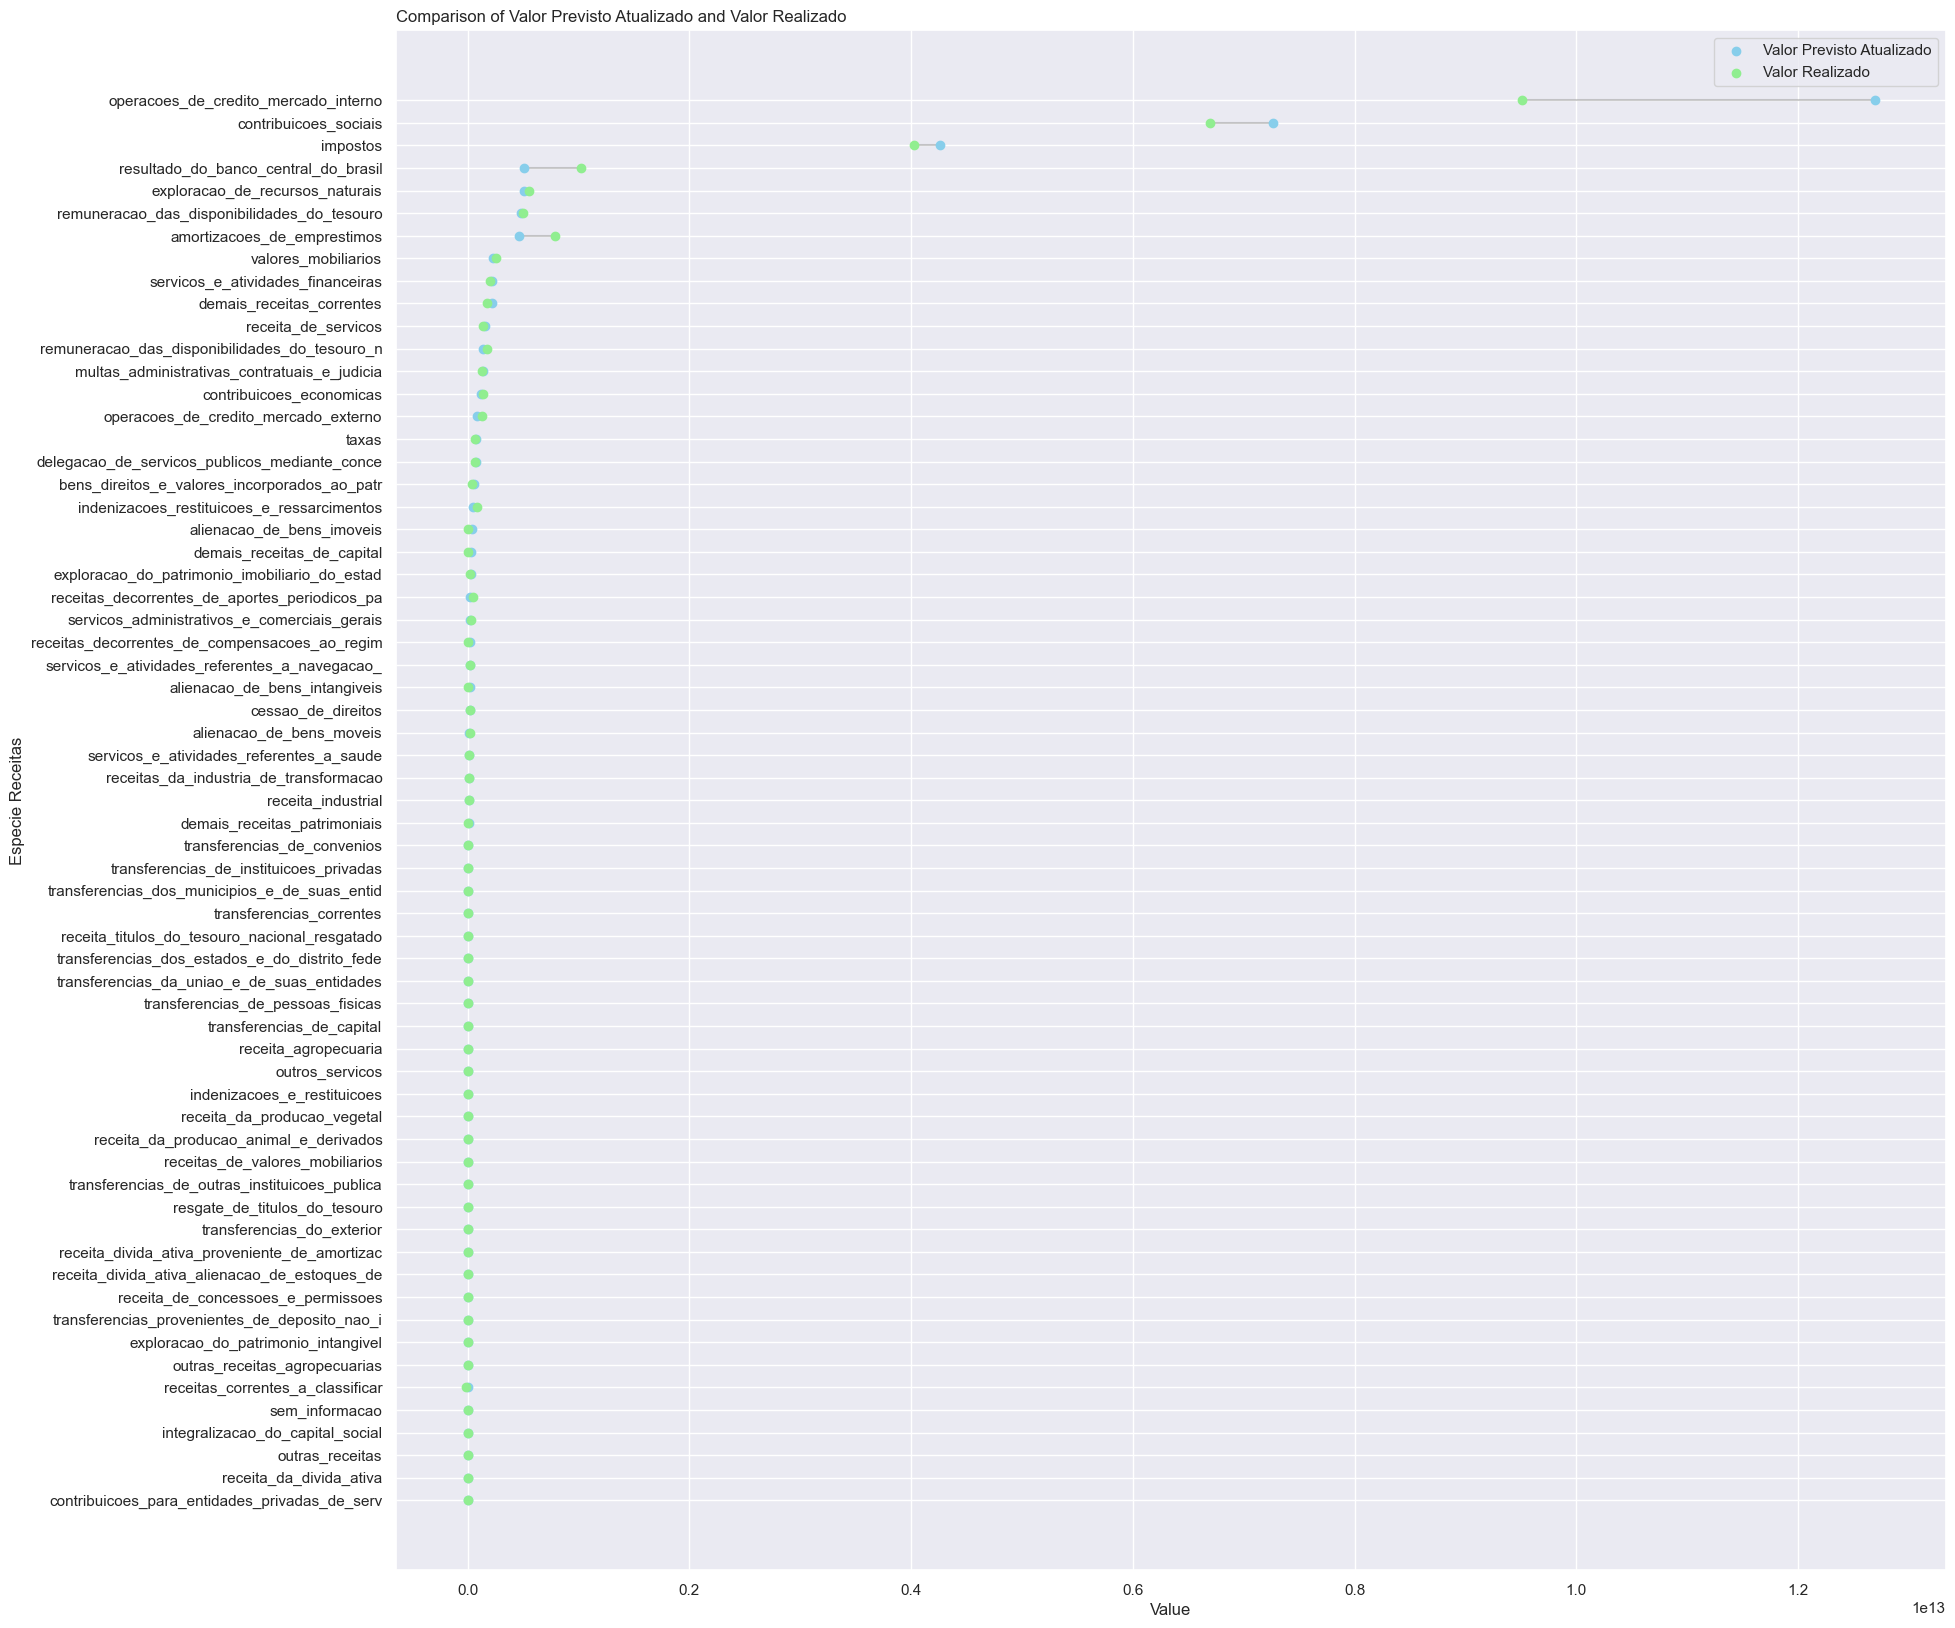

In [ ]:
plt.figure(figsize=(20,20))

summarized_df = cleaned_data_df.groupby('especie_receita').agg({
                                'valor_previsto_atualizado': 'sum',
                                'valor_realizado': 'sum'
                            }).reset_index()


ordered_df = summarized_df.sort_values(by='valor_previsto_atualizado')
my_range = range(1, len(ordered_df.index) + 1)

plt.hlines(y=my_range, xmin=ordered_df['valor_previsto_atualizado'], xmax=ordered_df['valor_realizado'], color='grey', alpha=0.4, zorder=1)
plt.scatter(ordered_df['valor_previsto_atualizado'], my_range, color='skyblue', alpha=1, label='Valor Previsto Atualizado')
plt.scatter(ordered_df['valor_realizado'], my_range, color='lightgreen', alpha=1, label='Valor Realizado')


plt.legend()
plt.yticks(my_range, ordered_df['especie_receita'])
plt.title("Comparison of Valor Previsto Atualizado and Valor Realizado", loc='left')
plt.xlabel('Value')
plt.ylabel('Especie Receitas')
plt.show()


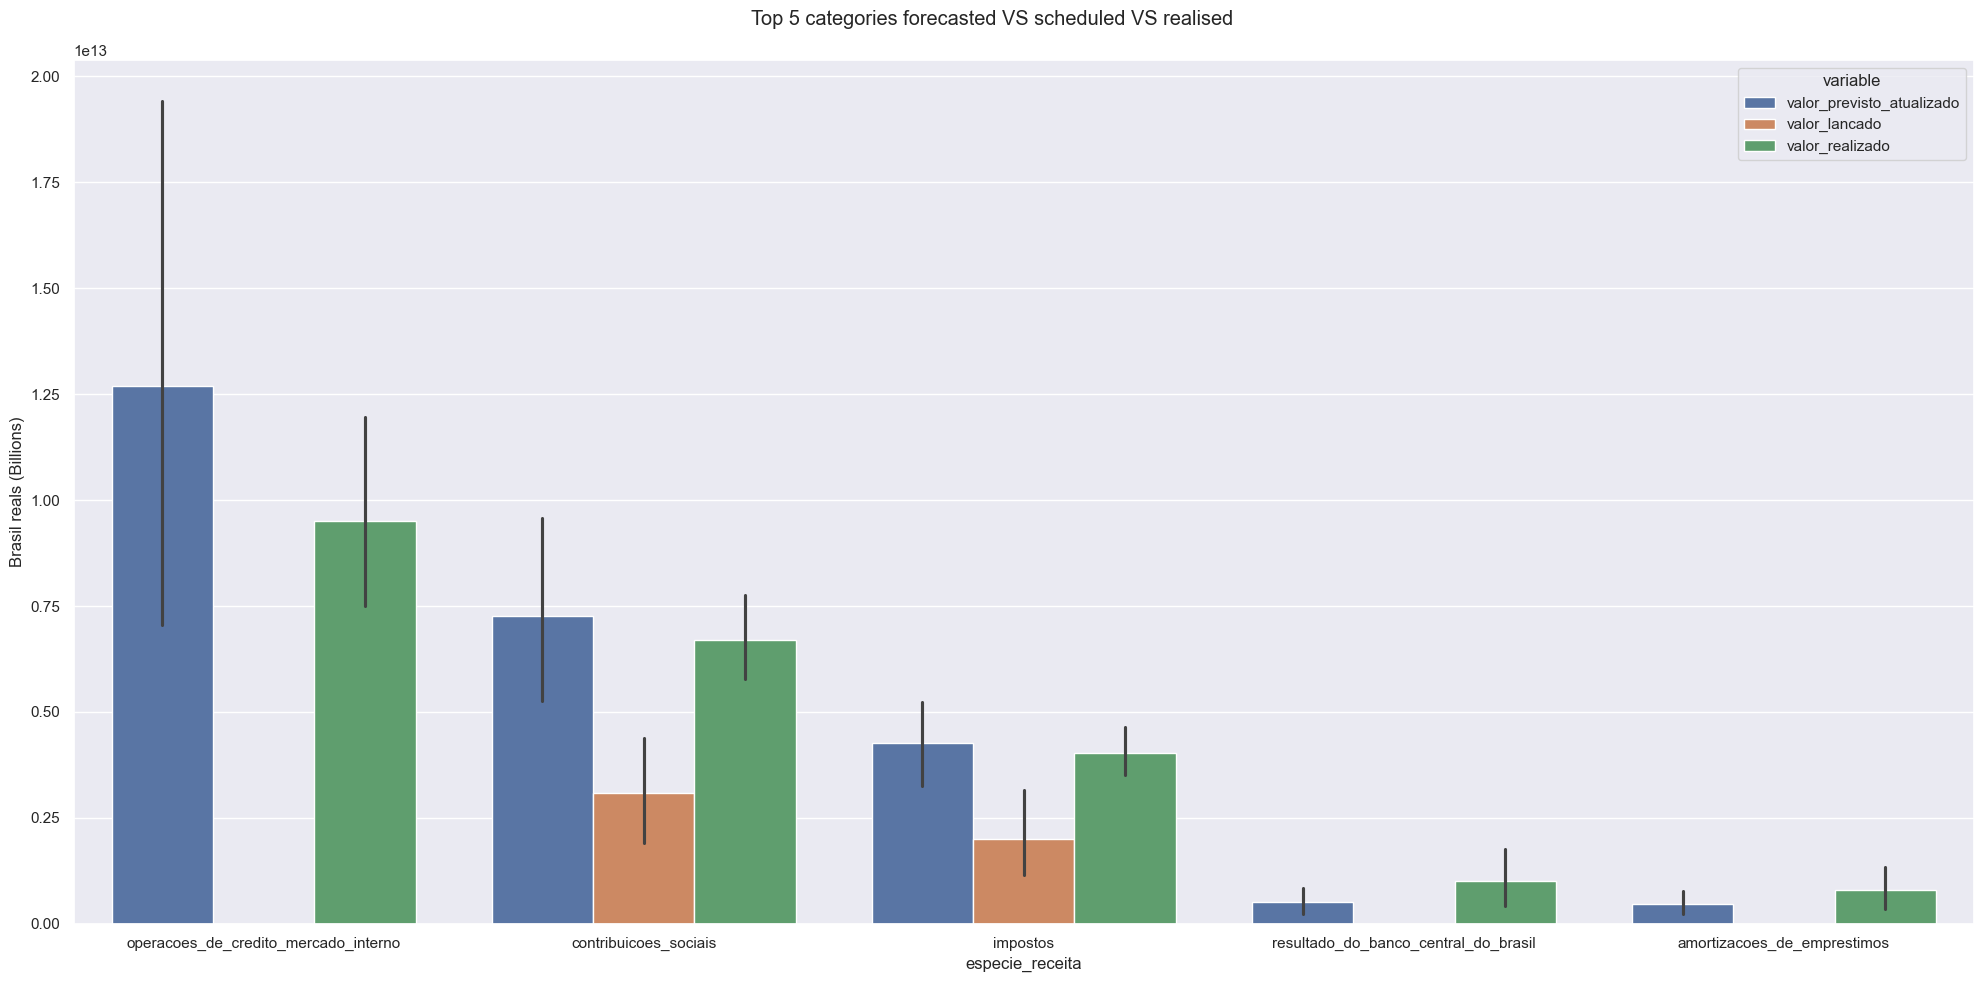

In [576]:
top5_filter = cleaned_data_df["especie_receita"].isin(contribution_especie.index[:5].to_list())
top5_categories_melted = pd.melt(cleaned_data_df[top5_filter], id_vars=["ano_exercicio","month","especie_receita"] , value_vars=['valor_previsto_atualizado', 'valor_lancado','valor_realizado'])

plt.figure(figsize=(20,10))

plt.suptitle("Top 5 categories forecasted VS scheduled VS realised")
sns.barplot(data=top5_categories_melted,
            x="especie_receita",
            y="value",
        hue= "variable",
        estimator="sum",
        order=top5_especies)

plt.ylabel("Brasil reals (Billions)")
plt.tight_layout()
plt.show()

Annual evolution of forecast vs realised.

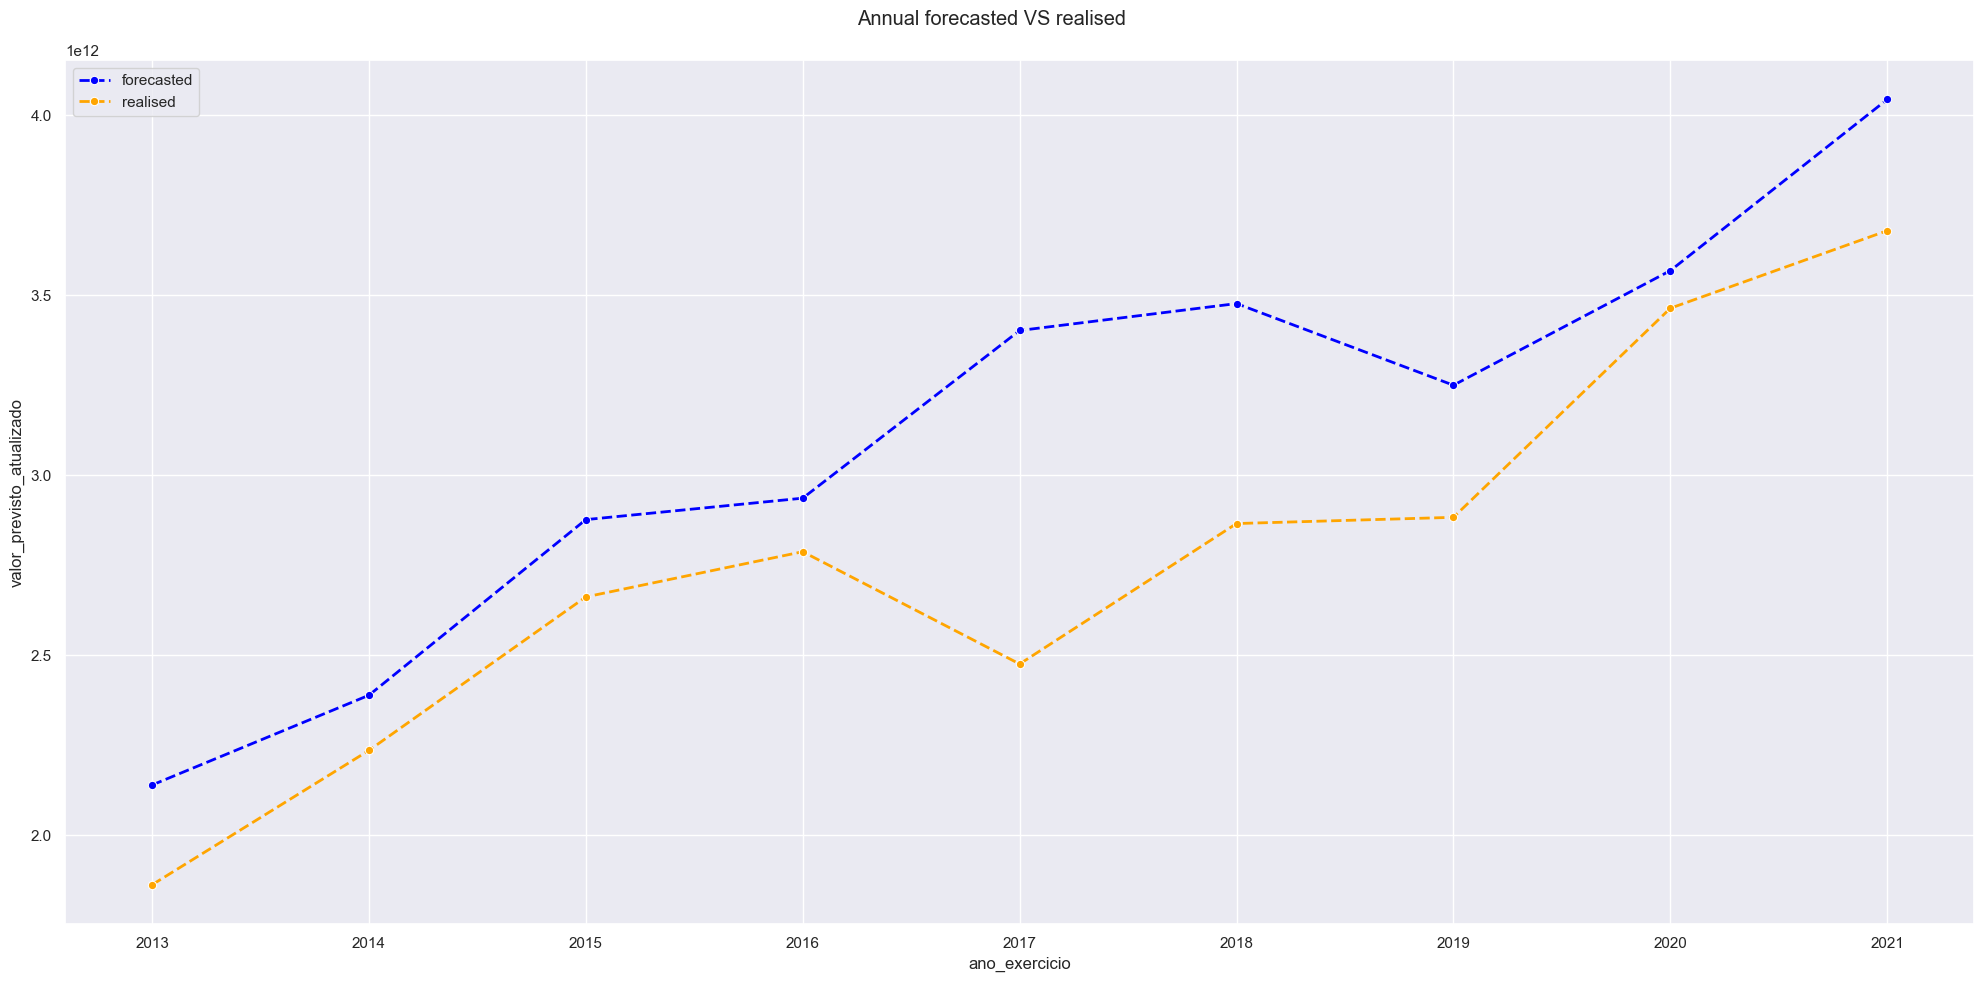

In [577]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))

plt.suptitle("Annual forecasted VS realised")
sns.lineplot(data=cleaned_data_df,
            x="ano_exercicio",
            y="valor_previsto_atualizado",
        marker = "o", 
        linewidth = 2, 
        label="forecasted",
        color="blue", 
        linestyle = "dashed",
        estimator="sum",
        errorbar=None)
sns.lineplot(data=cleaned_data_df,
    x="ano_exercicio",
    y="valor_realizado",
    marker = "o", 
    linewidth = 2, 
    label="realised", 
    color="orange", 
    linestyle = "dashed",
    estimator="sum",
    errorbar=None)

plt.tight_layout()
plt.show()

Contribution of top 5 contributing categories per year.

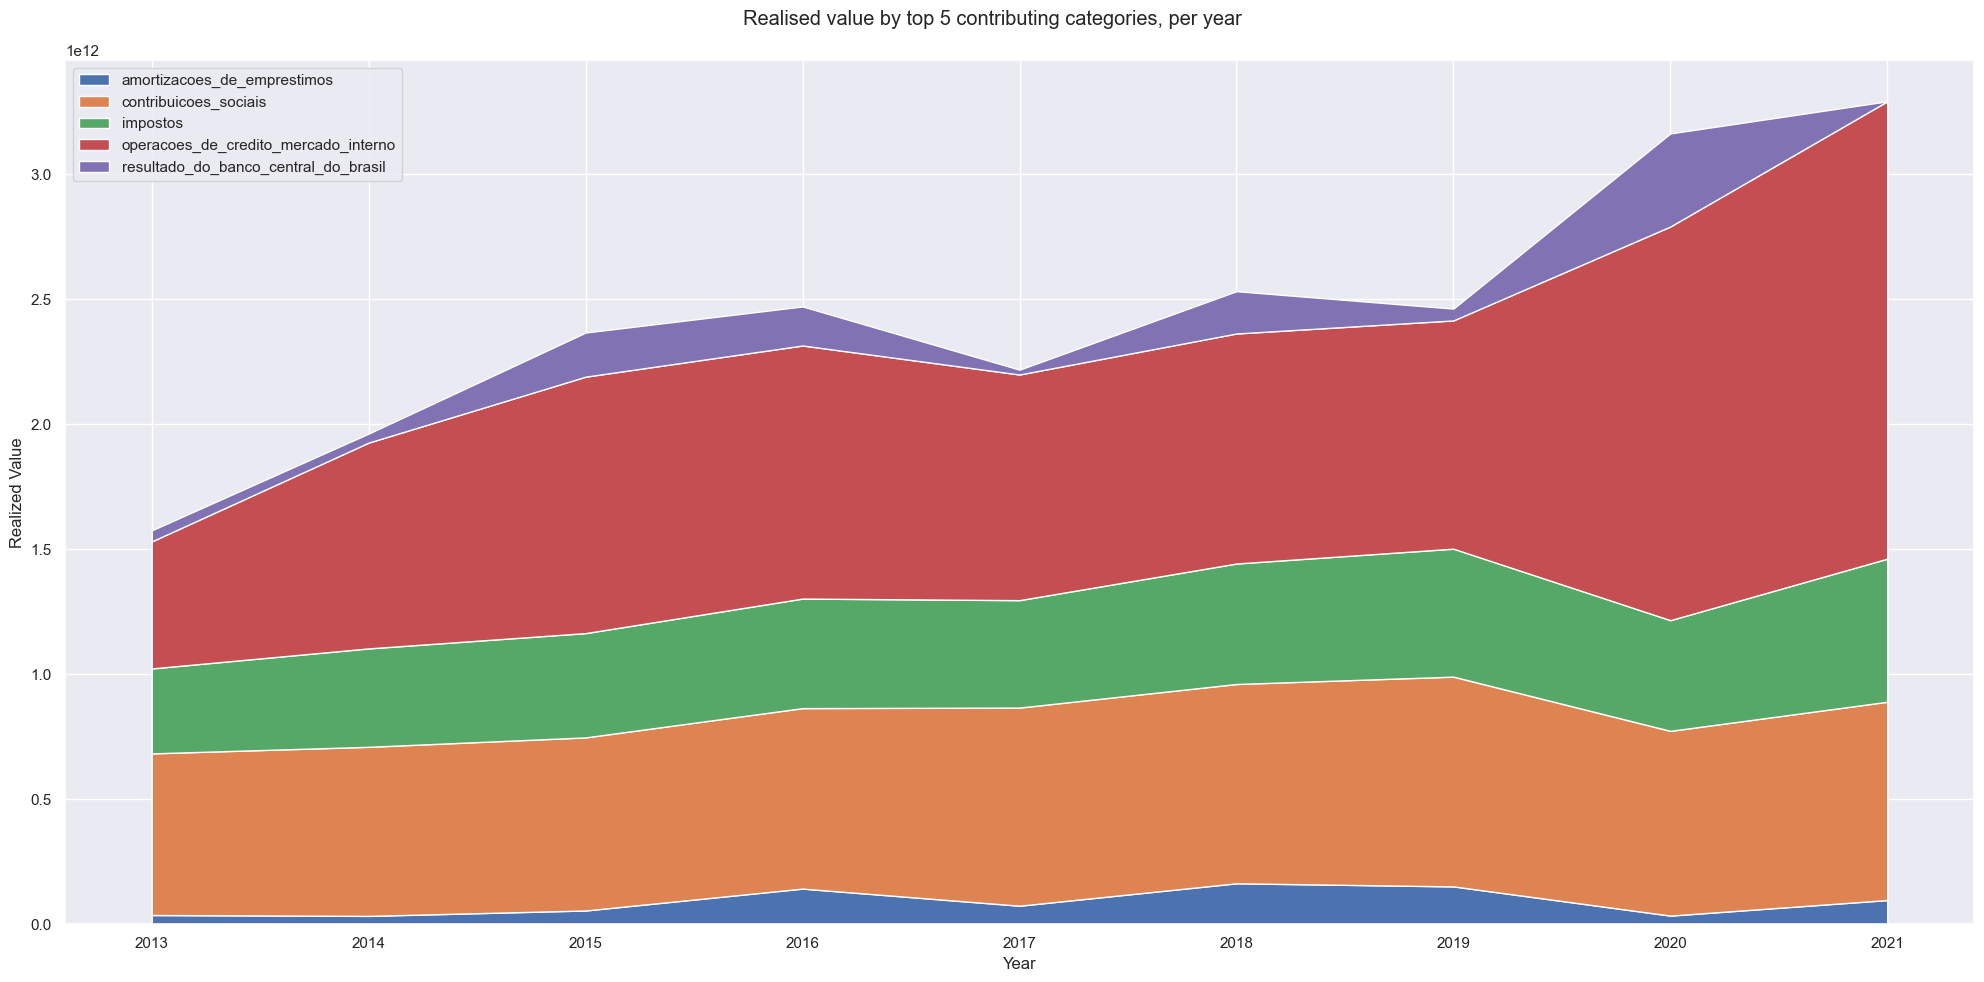

In [585]:

plt.figure(figsize=(20,10))
plt.suptitle("Realised value by top 5 contributing categories, per year")

data_pivot = cleaned_data_df[top5_filter].pivot_table(
    index="ano_exercicio", 
    columns="especie_receita", 
    values="valor_realizado", 
    aggfunc="sum"
).fillna(0)

plt.stackplot(data_pivot.index, data_pivot.T, labels=data_pivot.columns)

plt.xlabel("Year")
plt.ylabel("Realized Value")
plt.legend(loc="upper left")

plt.tight_layout()
plt.show()


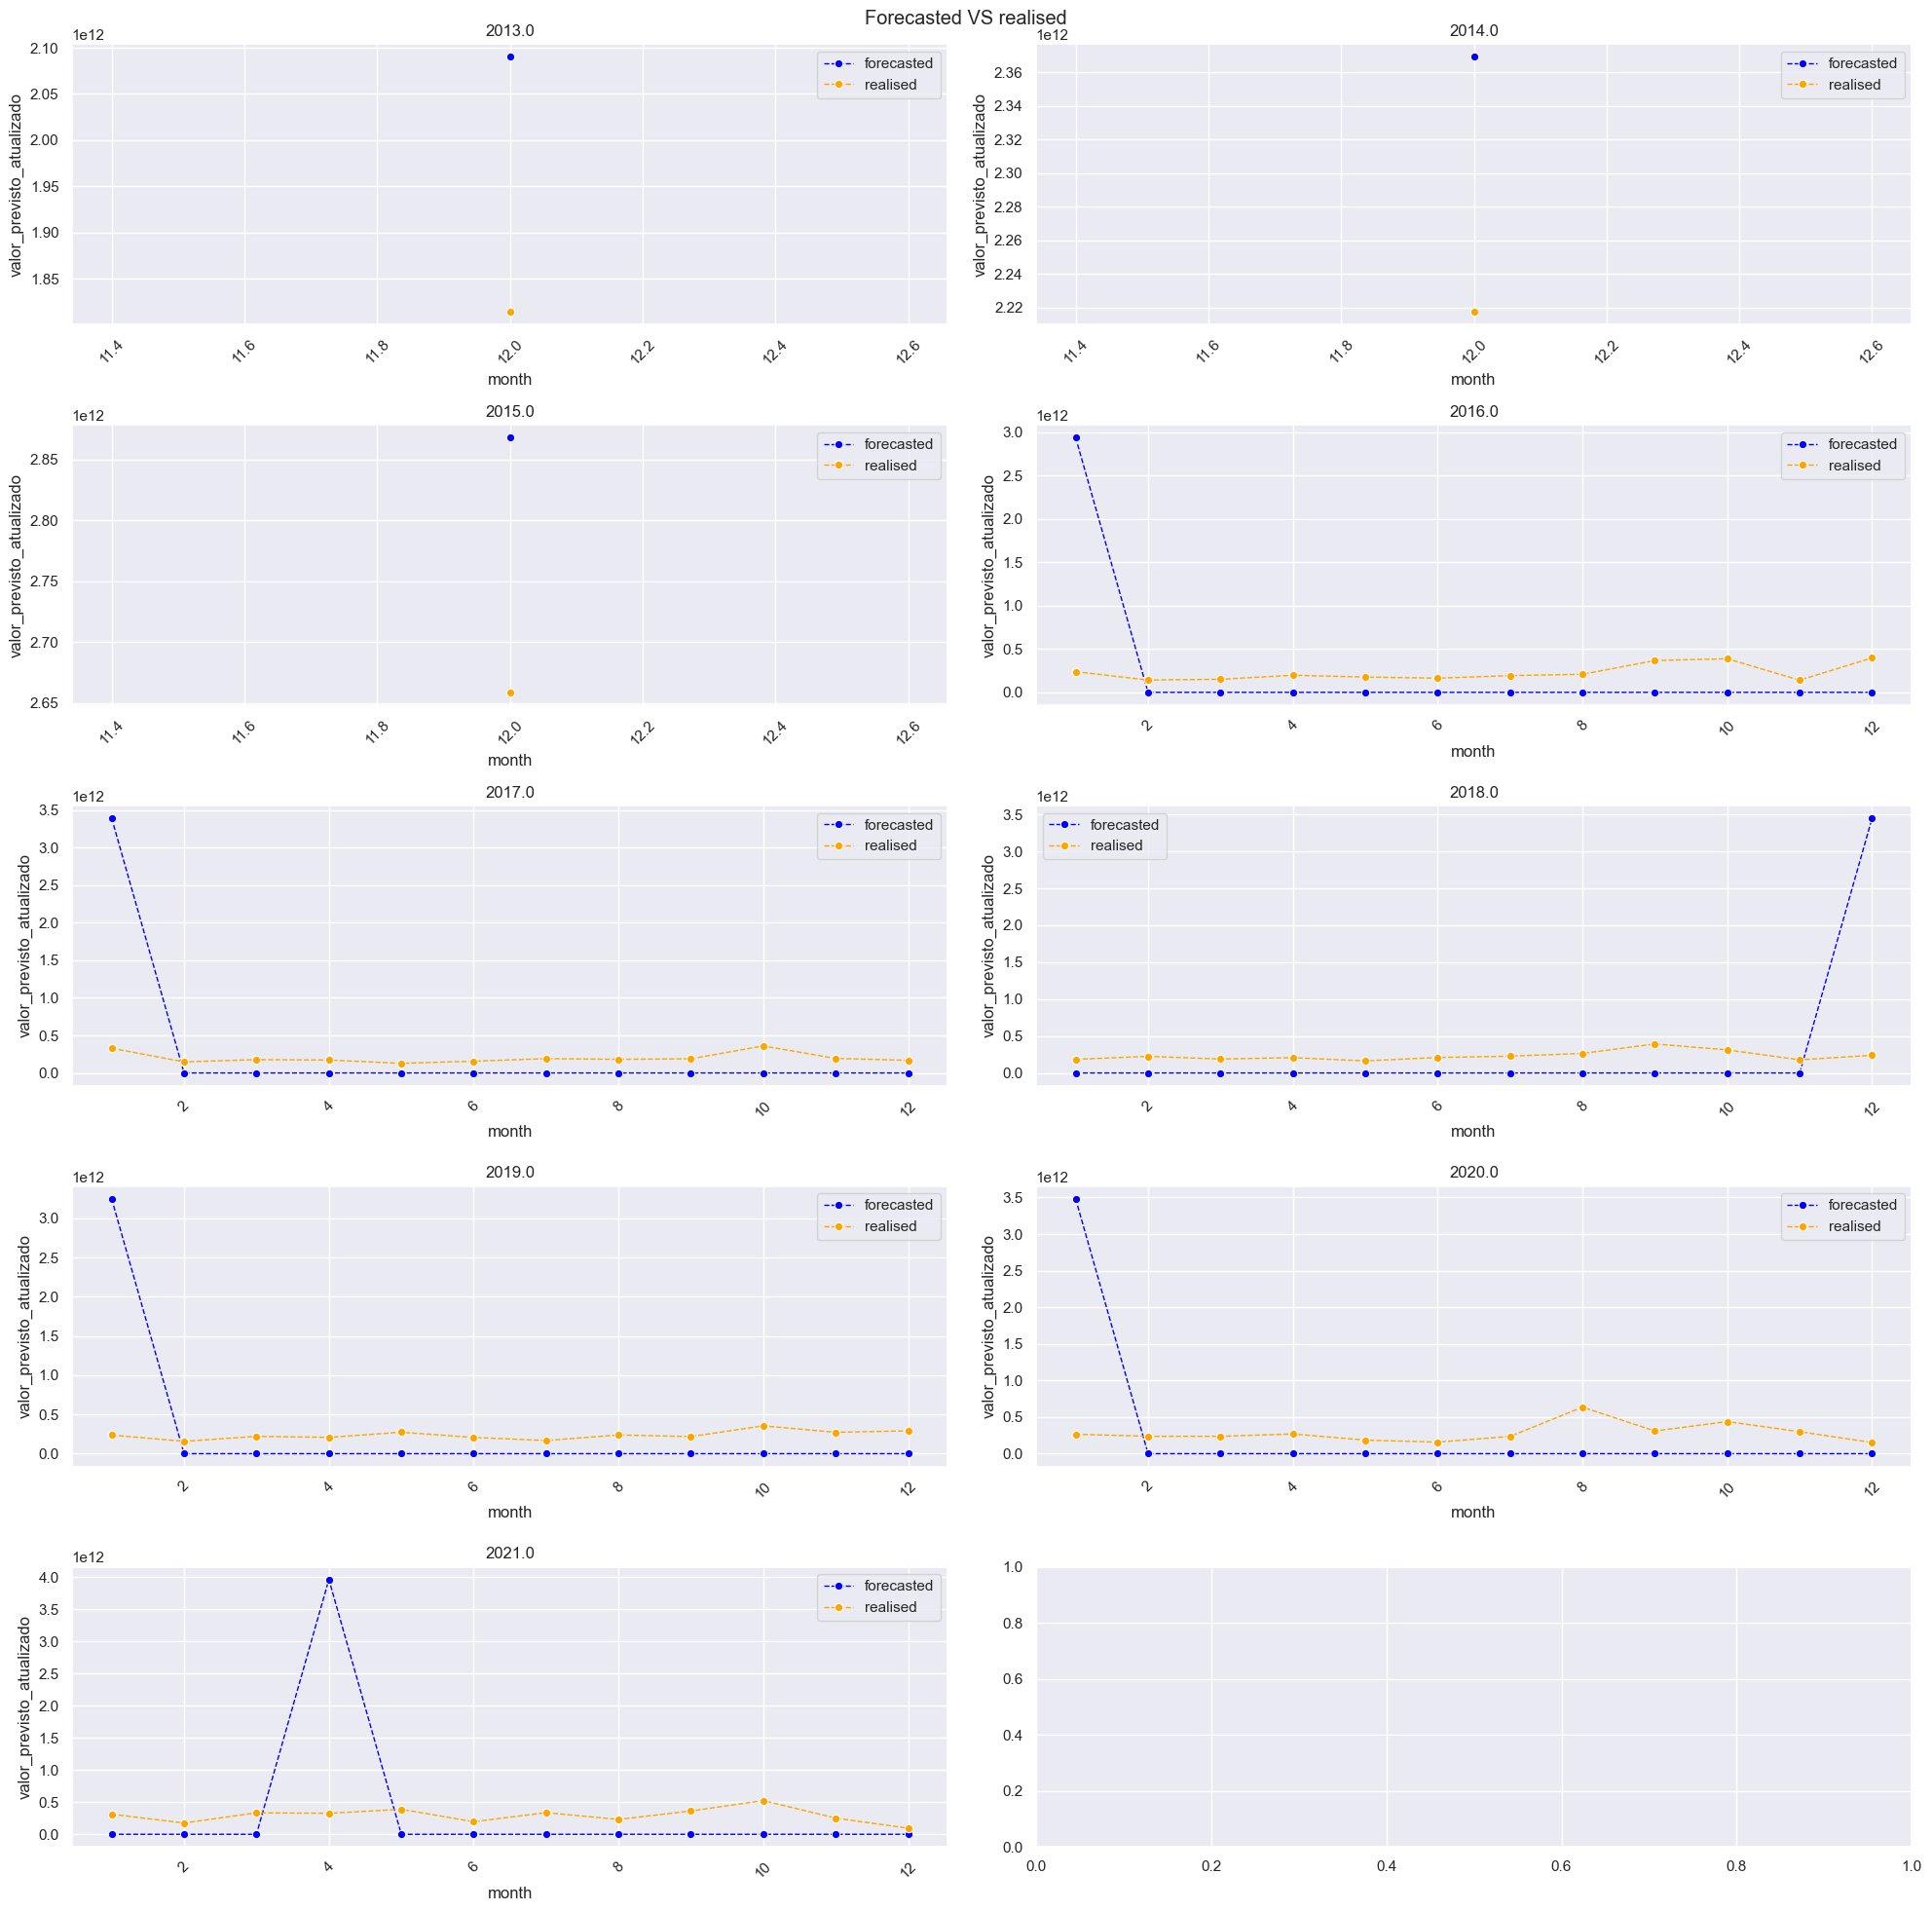

In [571]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(5,2,figsize=(20,20))

axes = axes.flat

plt.suptitle("Forecasted VS realised")
for ax, year in enumerate(cleaned_data_df["ano_exercicio"].unique()):
    axes[ax].set_title(year)
    sns.lineplot(data=cleaned_data_df[cleaned_data_df["ano_exercicio"]==year],
             x="month",
             y="valor_previsto_atualizado",
            marker = "o", 
            linewidth = 1, 
            label="forecasted",
            color="blue", 
            linestyle = "dashed", 
            errorbar = None,
            ax=axes[ax],
            estimator="sum")
    sns.lineplot(data=cleaned_data_df[cleaned_data_df["ano_exercicio"]==year],
        x="month",
        y="valor_realizado",
        marker = "o", 
        linewidth = 1, 
        label="realised", 
        color="orange", 
        linestyle = "dashed", 
        errorbar = None,
        ax=axes[ax],
        estimator="sum")
    axes[ax].tick_params(axis='x', labelrotation=45)

plt.tight_layout()
plt.show()

### Distributions

In [579]:
value_features = ["valor_previsto_atualizado","valor_lancado","valor_realizado","percentual_realizado","diff_valor_previsto_realizado"]
contribution_especie_top10 = contribution_especie[:10].index.to_list()

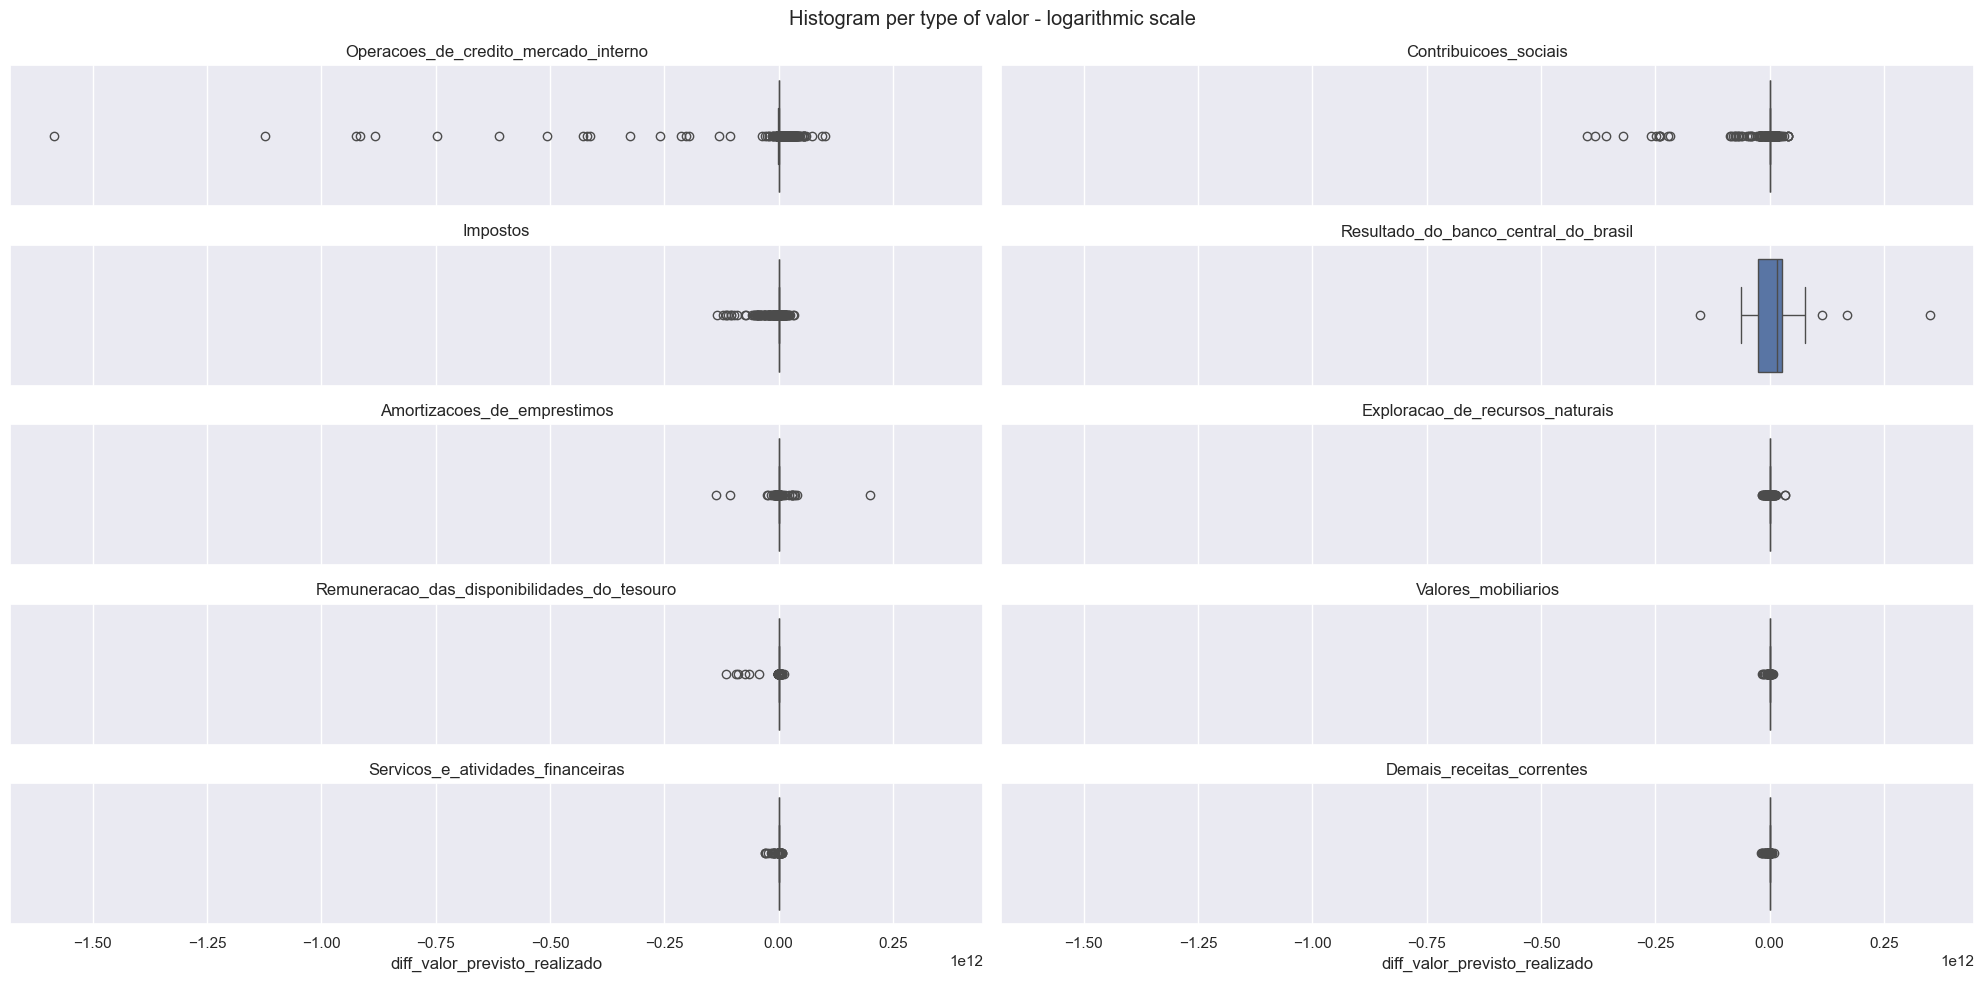

In [580]:
fig, axes = plt.subplots(5,2,figsize=(20,10), sharex=True)

axes = axes.flat

plt.suptitle("Histogram per type of valor - linear scale")
for ax, especie in enumerate(contribution_especie_top10):
    # axes[ax].set_xscale("log")
    axes[ax].set_title(especie.capitalize())
    sns.boxplot(data = cleaned_data_df.query('especie_receita == @especie'), x="diff_valor_previsto_realizado", ax=axes[ax])

plt.tight_layout()
plt.show()

In [581]:
pd.set_option("display.max_rows",65)
contribution_especie = cleaned_data_df.groupby(["nome_unidade_gestora"])[["valor_realizado"]].sum().assign(valor_realizado_pct=lambda x: np.round(x["valor_realizado"]/cleaned_data_df["valor_realizado"].sum()*100,2)).sort_values("valor_realizado",ascending=False)
contribution_especie[0:10]

,valor_realizado,valor_realizado_pct
nome_unidade_gestora,,
setorial_orcamentaria_e_financeira_me,2.025004e+13,81.27
coordenacao_de_orcamento_e_financas_do_frgps,2.949998e+12,11.84
coord_geral_de_orcamento_fin_e_cont_cgofc,3.418336e+11,1.37
coord_geral_de_orcamento_financas_e_contab_,3.179950e+11,1.28
fundo_nacional_de_desenvolvimento_da_educacao,2.050627e+11,0.82
ag_nac_do_petroleo_gas_nat_e_biocom,9.032010e+10,0.36
fundo_da_marinha_mercante,6.469677e+10,0.26
agencia_nacional_de_energia_eletrica,6.042861e+10,0.24
fundo_nacional_de_aviacao_civil,4.088000e+10,0.16


In [582]:
pd.set_option("display.max_rows",65)
contribution_especie = cleaned_data_df.groupby(["nome_orgao"])[["valor_realizado"]].sum().assign(valor_realizado_pct=lambda x: np.round(x["valor_realizado"]/cleaned_data_df["valor_realizado"].sum()*100,2)).sort_values("valor_realizado",ascending=False)
contribution_especie[0:10]

,valor_realizado,valor_realizado_pct
nome_orgao,,
ministerio_da_economia_unidades_com_vinculo_direto,2.027778e+13,81.38
fundo_do_regime_geral_da_previdencia_social,2.949998e+12,11.84
fundo_de_amparo_ao_trabalhador,3.418336e+11,1.37
instituto_nacional_do_seguro_social,3.179950e+11,1.28
fundo_nacional_de_desenvolvimento_da_educacao,2.050627e+11,0.82
agencia_nacional_do_petroleo_gas_natural_e_biocombustiveis,9.032010e+10,0.36
departamento_do_fundo_da_marinha_mercante,6.469677e+10,0.26
agencia_nacional_de_energia_eletrica,6.042861e+10,0.24
fundo_nacional_de_aviacao_civil,4.088000e+10,0.16


In general, it seems that smaller, non financially related entities perform better than bigger ones.

In [583]:
yearly_total_category = cleaned_data_df.groupby(['ano_exercicio', 'nome_orgao'])[['diff_valor_previsto_realizado',"valor_realizado"]].sum().reset_index()
mean_yearly_revenue_category = yearly_total_category.groupby('nome_orgao')[['diff_valor_previsto_realizado',"valor_realizado"]].mean().reset_index()
mean_yearly_revenue_category.columns = ["nome_orgao","mean_yearly_revenue_diff","valor_realizado"]

(mean_yearly_revenue_category.assign(revenue_diff_pct= lambda x: np.round(x["mean_yearly_revenue_diff"]/x["mean_yearly_revenue_diff"].sum()*100,2))
                            .assign(revenue_diff_valor_realizado_pct=lambda x: np.round(x["mean_yearly_revenue_diff"]/x["valor_realizado"]*100,2))
                            .sort_values(by="mean_yearly_revenue_diff"))

,nome_orgao,mean_yearly_revenue_diff,valor_realizado,revenue_diff_pct,revenue_diff_valor_realizado_pct
200,ministerio_da_economia_unidades_com_vinculo_di...,-1.982981e+11,2.253087e+12,47.21,-8.80
119,fundo_do_regime_geral_da_previdencia_social,-1.063372e+11,3.687498e+11,25.32,-28.84
201,ministerio_da_educacao_unidades_com_vinculo_di...,-3.006450e+10,5.670160e+07,7.16,-53022.31
210,ministerio_de_minas_e_energia_unidades_com_vin...,-2.949764e+10,3.571339e+08,7.02,-8259.55
104,fundo_de_amparo_ao_trabalhador,-2.750418e+10,3.798151e+10,6.55,-72.41
...,...,...,...,...,...
228,servico_federal_de_processamento_de_dados,1.872276e+09,1.928941e+09,-0.45,97.06
113,fundo_de_garantia_a_exportacao,2.070589e+09,3.352354e+09,-0.49,61.77
6,agencia_nacional_de_mineracao,3.353303e+09,5.214237e+09,-0.80,64.31
12,agencia_nacional_do_petroleo_gas_natural_e_bio...,5.090517e+09,1.003557e+10,-1.21,50.72


In [584]:
yearly_total_category = cleaned_data_df.groupby(['ano_exercicio', 'nome_unidade_gestora'])[['diff_valor_previsto_realizado',"valor_realizado"]].sum().reset_index()
mean_yearly_revenue_category = yearly_total_category.groupby('nome_unidade_gestora')[['diff_valor_previsto_realizado',"valor_realizado"]].mean().reset_index()
mean_yearly_revenue_category.columns = ["nome_unidade_gestora","mean_yearly_revenue_diff","valor_realizado"]

(mean_yearly_revenue_category.assign(revenue_diff_pct= lambda x: np.round(x["mean_yearly_revenue_diff"]/x["mean_yearly_revenue_diff"].sum()*100,2))
                            .assign(revenue_diff_valor_realizado_pct=lambda x: np.round(x["mean_yearly_revenue_diff"]/x["valor_realizado"]*100,2))
                            .sort_values(by="mean_yearly_revenue_diff"))

,nome_unidade_gestora,mean_yearly_revenue_diff,valor_realizado,revenue_diff_pct,revenue_diff_valor_realizado_pct
290,setorial_orcamentaria_e_financeira_me,-1.997456e+11,2.250004e+12,47.36,-8.88
54,coordenacao_de_orcamento_e_financas_do_frgps,-1.063372e+11,3.687498e+11,25.21,-28.84
298,subsecretaria_de_planej_e_orcamento_spo_mec_,-3.006450e+10,5.670160e+07,7.13,-53022.31
45,coord_geral_de_orcam_e_fin_m_m_e,-2.949764e+10,3.571339e+08,6.99,-8259.55
48,coord_geral_de_orcamento_fin_e_cont_cgofc,-2.750418e+10,3.798151e+10,6.52,-72.41
...,...,...,...,...,...
284,serpro_sede_departamento_financeiro,1.872276e+09,1.928941e+09,-0.44,97.06
146,fundo_de_garantia_a_exportacao_bndes,2.070589e+09,3.352354e+09,-0.49,61.77
286,setorial_orcamentaria_e_financeira_anm,3.353303e+09,5.214237e+09,-0.79,64.31
0,ag_nac_do_petroleo_gas_nat_e_biocom,5.090517e+09,1.003557e+10,-1.21,50.72


### 5. Conclusions

- Top disrupting forecast VS revenue categories hold 90% of realized value weight.
- In 2017, a decrease in revenue by 'operacoes_de_credito_mercado_interno' and the national bank created the breach in forecast VS revenue.
- Differences in forecast VS realised are bigger in certain months that tend to fall at the end or beginning of the year. The exception is 2021, where the forecast is made in march. Recommendation: Prepare forecast at the end of the year to present it in January.